In [125]:
%matplotlib inline

import scipy.stats as stats
import math
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pylab as plt
from pathlib import Path
from datetime import datetime
from scipy.stats import chi2_contingency
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, PrecisionRecallDisplay
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

!pip install forex_python
from forex_python.converter import CurrencyRates
!pip install dmba
from dmba import plotDecisionTree, classificationSummary, gainsChart, liftChart
!pip install shap
import shap

# 1.0 Data Preparation

The employee attrition dataset we selected consists of 5 sub-datasets: general_data (employee data), employee_survey_data (survey results of job satisfaction), manager_survey_data (survey results of job performance), in_time (clock-in attendance data), and out_time (clock-out attendance data). During the Data Preparation stage, we merge all the 5 sub-datasets into a single dataframe, which will be used in the Exploratory Data Analysis.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
Import datasets from google drive

general = pd.read_csv('/content/drive/MyDrive/Capstone/general_data.csv')
emp_survey = pd.read_csv('/content/drive/MyDrive/Capstone/employee_survey_data.csv')
mgr_survey = pd.read_csv('/content/drive/MyDrive/Capstone/manager_survey_data.csv')
intime = pd.read_csv('/content/drive/MyDrive/Capstone/in_time.csv')
outtime = pd.read_csv('/content/drive/MyDrive/Capstone/out_time.csv')

In [7]:
# Check data structure for intime and outtime datasets to see if they have the same number of rows and columns

print(intime.shape)
print(outtime.shape)

(4410, 262)
(4410, 262)


In [8]:
intime.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


In [9]:
# Add a column name to the first column (EmployeeID)

intime = intime.rename({'Unnamed: 0':'EmployeeID'}, axis=1)
intime.head()

,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


In [10]:
# Transpsoe the date features from horizontal to vertical

intime = intime.melt(id_vars=['EmployeeID'],
                     var_name='Date',
                     value_name='inTime')
intime.tail()

,EmployeeID,Date,inTime
1151005,4406,2015-12-31,2015-12-31 10:00:12
1151006,4407,2015-12-31,2015-12-31 10:09:48
1151007,4408,2015-12-31,2015-12-31 10:03:30
1151008,4409,2015-12-31,2015-12-31 09:56:47
1151009,4410,2015-12-31,2015-12-31 10:09:28


In [11]:
intime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151010 entries, 0 to 1151009
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   EmployeeID  1151010 non-null  int64 
 1   Date        1151010 non-null  object
 2   inTime      1041930 non-null  object
dtypes: int64(1), object(2)
memory usage: 26.3+ MB


***
N.B.

Above info() summary shows that inTime column has some missing values which is acceptable, because it indicates that the employee was absent from work on those dates
***

In [12]:
# Check missing values in EmployeeID and Date features

intime.isnull().sum()

EmployeeID         0
Date               0
inTime        109080
dtype: int64

In [13]:
# Repeat the same steps for outtime dataset

outtime = outtime.rename({'Unnamed: 0':'EmployeeID'},  axis=1)
outtime.head()

,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


In [14]:
outtime = outtime.melt(id_vars=['EmployeeID'],
                       var_name='Date',
                       value_name='outTime')
outtime.tail()

,EmployeeID,Date,outTime
1151005,4406,2015-12-31,2015-12-31 18:30:41
1151006,4407,2015-12-31,2015-12-31 16:18:39
1151007,4408,2015-12-31,2015-12-31 18:08:55
1151008,4409,2015-12-31,2015-12-31 19:33:45
1151009,4410,2015-12-31,2015-12-31 16:39:18


In [15]:
outtime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151010 entries, 0 to 1151009
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   EmployeeID  1151010 non-null  int64 
 1   Date        1151010 non-null  object
 2   outTime     1041930 non-null  object
dtypes: int64(1), object(2)
memory usage: 26.3+ MB


In [16]:
outtime.isnull().sum()

EmployeeID         0
Date               0
outTime       109080
dtype: int64

In [17]:
# Merge intime and outtime datasets using EmployeeID and Date features as primary key

daytime = pd.merge(intime, outtime, how='left', left_on=['EmployeeID','Date'], right_on=['EmployeeID','Date'])
daytime.tail()

,EmployeeID,Date,inTime,outTime
1151005,4406,2015-12-31,2015-12-31 10:00:12,2015-12-31 18:30:41
1151006,4407,2015-12-31,2015-12-31 10:09:48,2015-12-31 16:18:39
1151007,4408,2015-12-31,2015-12-31 10:03:30,2015-12-31 18:08:55
1151008,4409,2015-12-31,2015-12-31 09:56:47,2015-12-31 19:33:45
1151009,4410,2015-12-31,2015-12-31 10:09:28,2015-12-31 16:39:18


In [18]:
daytime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151010 entries, 0 to 1151009
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   EmployeeID  1151010 non-null  int64 
 1   Date        1151010 non-null  object
 2   inTime      1041930 non-null  object
 3   outTime     1041930 non-null  object
dtypes: int64(1), object(3)
memory usage: 43.9+ MB


In [19]:
# Change Date, inTime and outTime features to datetime format

daytime['Date'] = pd.to_datetime(daytime.Date, format='%Y-%m-%d')
daytime['inTime'] = pd.to_datetime(daytime.inTime)
daytime['outTime'] = pd.to_datetime(daytime.outTime)

In [20]:
daytime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151010 entries, 0 to 1151009
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   EmployeeID  1151010 non-null  int64         
 1   Date        1151010 non-null  datetime64[ns]
 2   inTime      1041930 non-null  datetime64[ns]
 3   outTime     1041930 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(1)
memory usage: 43.9 MB


In [21]:
# Calculate working hours for each employee per day

daytime['WorkHrs'] = ((daytime.outTime - daytime.inTime).dt.seconds)/3600
daytime.tail()

,EmployeeID,Date,inTime,outTime,WorkHrs
1151005,4406,2015-12-31,2015-12-31 10:00:12,2015-12-31 18:30:41,8.508056
1151006,4407,2015-12-31,2015-12-31 10:09:48,2015-12-31 16:18:39,6.147500
1151007,4408,2015-12-31,2015-12-31 10:03:30,2015-12-31 18:08:55,8.090278
1151008,4409,2015-12-31,2015-12-31 09:56:47,2015-12-31 19:33:45,9.616111
1151009,4410,2015-12-31,2015-12-31 10:09:28,2015-12-31 16:39:18,6.497222


In [22]:
# Calculate average working hours and total working days for each employee in the year

daytime_df = daytime.groupby(['EmployeeID']).agg({'WorkHrs':['mean','count']})
daytime_df.columns = ['AvgHrs','WkDays']
daytime_df.head()

,AvgHrs,WkDays
EmployeeID,,
1,7.373651,232
2,7.718969,236
3,7.013240,242
4,7.193678,235
5,8.006175,245


In [23]:
# Check missing values in employee survey dataset
# Missing values of all features will be handled in EDA

emp_survey.isnull().sum()

EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64

In [24]:
# Check missing values in manager survey dataset
# Missing values of all features will be handled in EDA

mgr_survey.isnull().sum()

EmployeeID           0
JobInvolvement       0
PerformanceRating    0
dtype: int64

In [25]:
# Merge average working hours, working days, employee and manager survey data into employee general dataset 

df = pd.merge(general, daytime_df, how = 'left', left_on=['EmployeeID'], right_on=['EmployeeID'])
df = pd.merge(df, emp_survey, how = 'left', left_on=['EmployeeID'], right_on=['EmployeeID'])
df = pd.merge(df, mgr_survey, how = 'left', left_on=['EmployeeID'], right_on=['EmployeeID'])

In [26]:
# Get real-time exchange rate for MonthlyIncome (rupees) to Canadian dollar

#c = CurrencyRates()
#rate = c.get_rate('INR', 'CAD')
rate = 0.016

In [27]:
# Create a new column of MonthlyIncome in Canadian dollar

df['MonthlyIncomeCAD'] = df.MonthlyIncome * rate
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsSinceLastPromotion,YearsWithCurrManager,AvgHrs,WkDays,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,MonthlyIncomeCAD
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,0,0,7.373651,232,3.0,4.0,2.0,3,3,2098.56
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,1,4,7.718969,236,3.0,2.0,4.0,2,4,670.24
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,0,3,7.013240,242,2.0,2.0,1.0,3,3,3092.48
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,7,5,7.193678,235,4.0,4.0,3.0,2,3,1331.36
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,0,4,8.006175,245,4.0,1.0,3.0,3,3,374.72


In [28]:
# Change target variable to binary

df['Attrition'].replace(['No','Yes'], [0,1], inplace=True)

# Replace text values in categorical features with codes (e.g. 1, 2, 3, etc.)

df['BusinessTravel'].replace(['Non-Travel','Travel_Frequently','Travel_Rarely'], [1,2,3], inplace=True)
df['Department'].replace(['Human Resources','Research & Development','Sales'], [1,2,3], inplace=True)
df['EducationField'].replace(['Human Resources','Life Sciences','Marketing','Medical','Other','Technical Degree'], [1,2,3,4,5,6], inplace=True)
df['Gender'].replace(['Female','Male'], [0,1], inplace=True)
df['JobRole'].replace(['Healthcare Representative','Human Resources','Laboratory Technician','Manager','Manufacturing Director','Research Director','Research Scientist','Sales Executive','Sales Representative'], [1,2,3,4,5,6,7,8,9], inplace=True)
df['MaritalStatus'].replace(['Divorced','Married','Single'], [1,2,3], inplace=True)

df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsSinceLastPromotion,YearsWithCurrManager,AvgHrs,WkDays,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,MonthlyIncomeCAD
0,51,0,3,3,6,2,2,1,1,0,...,0,0,7.373651,232,3.0,4.0,2.0,3,3,2098.56
1,31,1,2,2,10,1,2,1,2,0,...,1,4,7.718969,236,3.0,2.0,4.0,2,4,670.24
2,32,0,2,2,17,4,5,1,3,1,...,0,3,7.013240,242,2.0,2.0,1.0,3,3,3092.48
3,38,0,1,2,2,5,2,1,4,1,...,7,5,7.193678,235,4.0,4.0,3.0,2,3,1331.36
4,32,0,3,2,10,1,4,1,5,1,...,0,4,8.006175,245,4.0,1.0,3.0,3,3,374.72


# 2.0 Exploratory Data Analysis

We verify and ensure that the data are in reasonable condition by applying various data exploration and cleaning techniques. We explore the data structure, check for duplicates and data uniqueness, identify and impute missing values. For numerical features, we visualize the distribution and handle outliers as well as skewness. For categorical features, we find out the correlation between each feature and the target variable. 

### 2.1 Data Structure

In [29]:
# Copy the merged dataset to a new dataframe
# Check number of rows and columns

emp_attr = df.copy()
emp_attr.shape

(4410, 32)

In [30]:
emp_attr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   int64  
 2   BusinessTravel           4410 non-null   int64  
 3   Department               4410 non-null   int64  
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   int64  
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   int64  
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   int64  
 12  MaritalStatus            4410 non-null   int64  
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

### 2.2 Data Quality

In [31]:
# Check duplicates

emp_attr.duplicated().any()

False

In [32]:
# Drop unnecessary features
# EmployeeCount, Over18 and StandardHours should be dropped as they only contain one unique value
# EmployeeID and MonthlyIncome variables are not useful for the analysis

emp_attr.drop(['EmployeeCount','Over18','StandardHours','EmployeeID','MonthlyIncome'], axis='columns', inplace=True)

In [33]:
emp_attr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   int64  
 2   BusinessTravel           4410 non-null   int64  
 3   Department               4410 non-null   int64  
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   int64  
 7   Gender                   4410 non-null   int64  
 8   JobLevel                 4410 non-null   int64  
 9   JobRole                  4410 non-null   int64  
 10  MaritalStatus            4410 non-null   int64  
 11  NumCompaniesWorked       4391 non-null   float64
 12  PercentSalaryHike        4410 non-null   int64  
 13  StockOptionLevel         4410 non-null   int64  
 14  TotalWorkingYears       

In [34]:
# Check number of unique values

emp_attr.nunique()

Age                          43
Attrition                     2
BusinessTravel                3
Department                    3
DistanceFromHome             29
Education                     5
EducationField                6
Gender                        2
JobLevel                      5
JobRole                       9
MaritalStatus                 3
NumCompaniesWorked           10
PercentSalaryHike            15
StockOptionLevel              4
TotalWorkingYears            40
TrainingTimesLastYear         7
YearsAtCompany               37
YearsSinceLastPromotion      16
YearsWithCurrManager         18
AvgHrs                     4410
WkDays                       24
EnvironmentSatisfaction       4
JobSatisfaction               4
WorkLifeBalance               4
JobInvolvement                4
PerformanceRating             2
MonthlyIncomeCAD           1349
dtype: int64

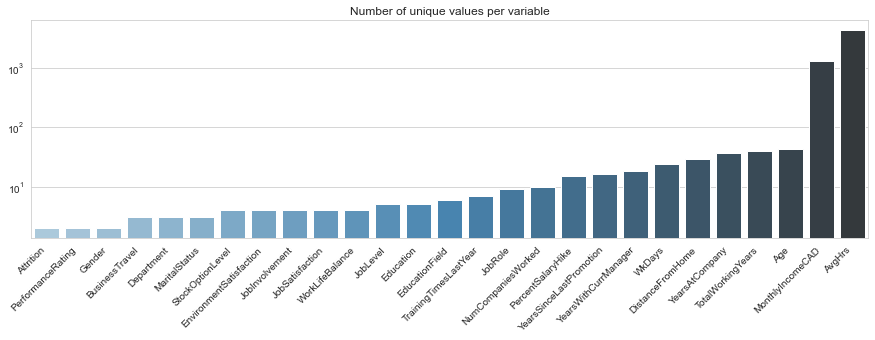

In [35]:
# Visualize the number of unique values

unique_values = emp_attr.nunique().sort_values()
plt.figure(figsize=(15,4))
sns.set_style('whitegrid')

g = sns.barplot(x=unique_values.index, y=unique_values,palette='Blues_d')
g.set_yscale('log')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('Number of unique values per variable')
plt.show()

In [36]:
# Check missing values

emp_attr.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
NumCompaniesWorked         19
PercentSalaryHike           0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
AvgHrs                      0
WkDays                      0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
MonthlyIncomeCAD            0
dtype: int64

<AxesSubplot:>

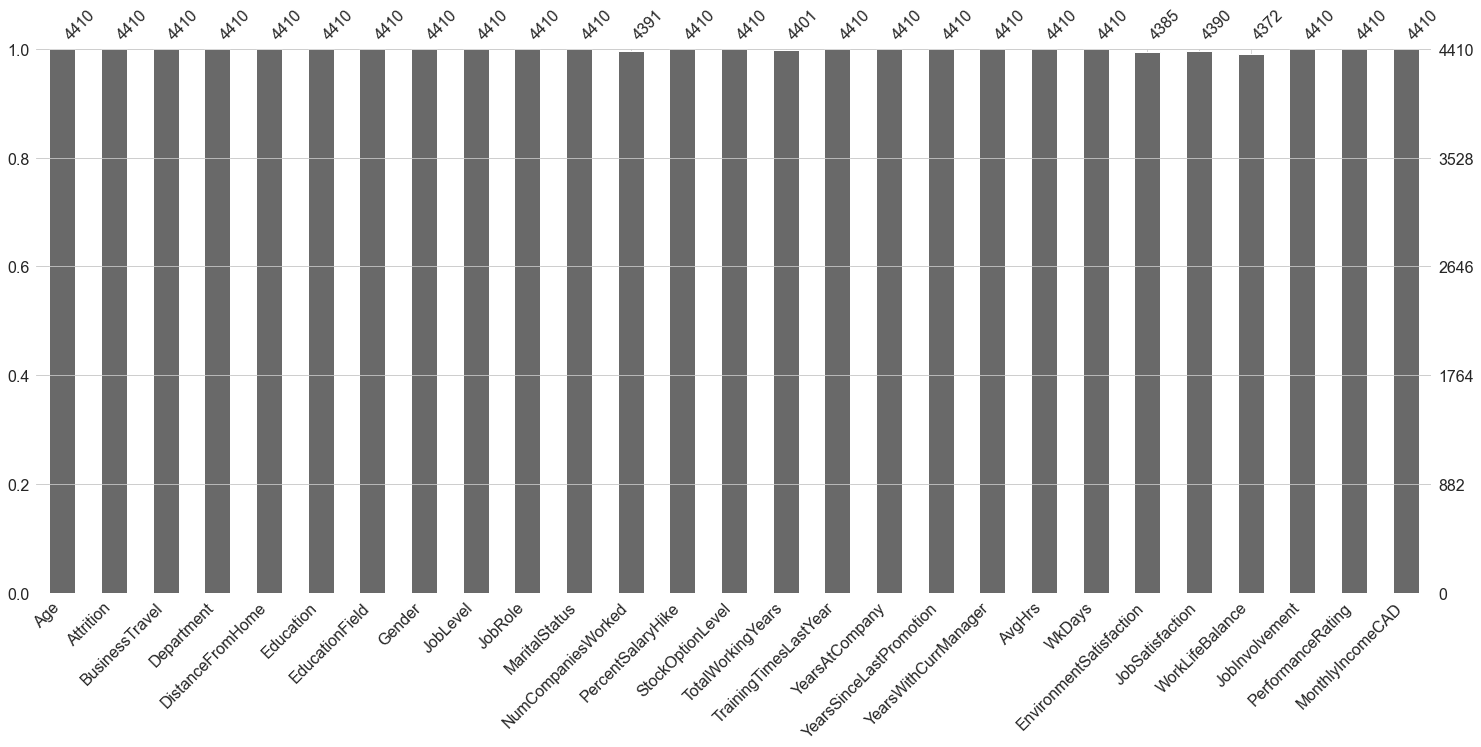

In [37]:
# Visualize missing values

msno.bar(emp_attr)

<AxesSubplot:title={'center':'Percentage of missing values per variable'}, ylabel='Ratio'>

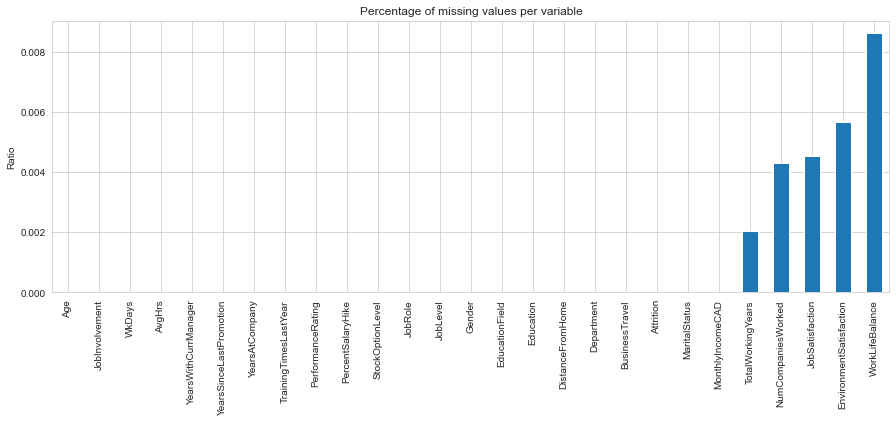

In [38]:
# Calculate the percentage of missing values 

emp_attr.isna().mean().sort_values().plot(
    kind='bar', figsize=(15,5),
    title='Percentage of missing values per variable',
    ylabel='Ratio')

In [39]:
# View statistics summary

emp_attr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,4410.0,36.923810,9.133301,18.000000,30.000000,36.000000,43.000000,60.00000
Attrition,4410.0,0.161224,0.367780,0.000000,0.000000,0.000000,0.000000,1.00000
BusinessTravel,4410.0,2.607483,0.665304,1.000000,2.000000,3.000000,3.000000,3.00000
Department,4410.0,2.260544,0.527673,1.000000,2.000000,2.000000,3.000000,3.00000
DistanceFromHome,4410.0,9.192517,8.105026,1.000000,2.000000,7.000000,14.000000,29.00000
Education,4410.0,2.912925,1.023933,1.000000,2.000000,3.000000,4.000000,5.00000
EducationField,4410.0,3.247619,1.331067,1.000000,2.000000,3.000000,4.000000,6.00000
Gender,4410.0,0.600000,0.489954,0.000000,0.000000,1.000000,1.000000,1.00000
JobLevel,4410.0,2.063946,1.106689,1.000000,1.000000,2.000000,3.000000,5.00000
JobRole,4410.0,5.458503,2.461263,1.000000,3.000000,6.000000,8.000000,9.00000


In [40]:
# Handle missing values using KNN imputation technique

imputer = KNNImputer(copy=False)
imputed = imputer.fit_transform(emp_attr)
emp_attr = pd.DataFrame(imputed, columns=emp_attr.columns)

In [41]:
# Check missing values after the imputation

emp_attr.isnull().sum()

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
NumCompaniesWorked         0
PercentSalaryHike          0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
AvgHrs                     0
WkDays                     0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
MonthlyIncomeCAD           0
dtype: int64

In [42]:
emp_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   float64
 1   Attrition                4410 non-null   float64
 2   BusinessTravel           4410 non-null   float64
 3   Department               4410 non-null   float64
 4   DistanceFromHome         4410 non-null   float64
 5   Education                4410 non-null   float64
 6   EducationField           4410 non-null   float64
 7   Gender                   4410 non-null   float64
 8   JobLevel                 4410 non-null   float64
 9   JobRole                  4410 non-null   float64
 10  MaritalStatus            4410 non-null   float64
 11  NumCompaniesWorked       4410 non-null   float64
 12  PercentSalaryHike        4410 non-null   float64
 13  StockOptionLevel         4410 non-null   float64
 14  TotalWorkingYears       

In [43]:
# Change all variables to integer except AvgHrs feature

ignore = ['AvgHrs']
emp_attr = (emp_attr.set_index(ignore, append=True).astype(int).reset_index(ignore))

In [44]:
emp_attr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AvgHrs                   4410 non-null   float64
 1   Age                      4410 non-null   int32  
 2   Attrition                4410 non-null   int32  
 3   BusinessTravel           4410 non-null   int32  
 4   Department               4410 non-null   int32  
 5   DistanceFromHome         4410 non-null   int32  
 6   Education                4410 non-null   int32  
 7   EducationField           4410 non-null   int32  
 8   Gender                   4410 non-null   int32  
 9   JobLevel                 4410 non-null   int32  
 10  JobRole                  4410 non-null   int32  
 11  MaritalStatus            4410 non-null   int32  
 12  NumCompaniesWorked       4410 non-null   int32  
 13  PercentSalaryHike        4410 non-null   int32  
 14  StockOptionLevel        

In [45]:
# Change some features to category based on the business context 

cat_list = ['BusinessTravel','Department','Education','EducationField','Gender',
            'JobLevel','JobRole','MaritalStatus','StockOptionLevel',
            'EnvironmentSatisfaction','JobSatisfaction','WorkLifeBalance',
            'JobInvolvement','PerformanceRating']
emp_attr[cat_list] = emp_attr[cat_list].astype('category')

In [46]:
emp_attr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   AvgHrs                   4410 non-null   float64 
 1   Age                      4410 non-null   int32   
 2   Attrition                4410 non-null   int32   
 3   BusinessTravel           4410 non-null   category
 4   Department               4410 non-null   category
 5   DistanceFromHome         4410 non-null   int32   
 6   Education                4410 non-null   category
 7   EducationField           4410 non-null   category
 8   Gender                   4410 non-null   category
 9   JobLevel                 4410 non-null   category
 10  JobRole                  4410 non-null   category
 11  MaritalStatus            4410 non-null   category
 12  NumCompaniesWorked       4410 non-null   int32   
 13  PercentSalaryHike        4410 non-null   int32   
 14  StockOpt

### 2.3 Variable Properties

#### 2.3.1 Numerical Features

##### 2.3.1.1 Central Tendency and Variation

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

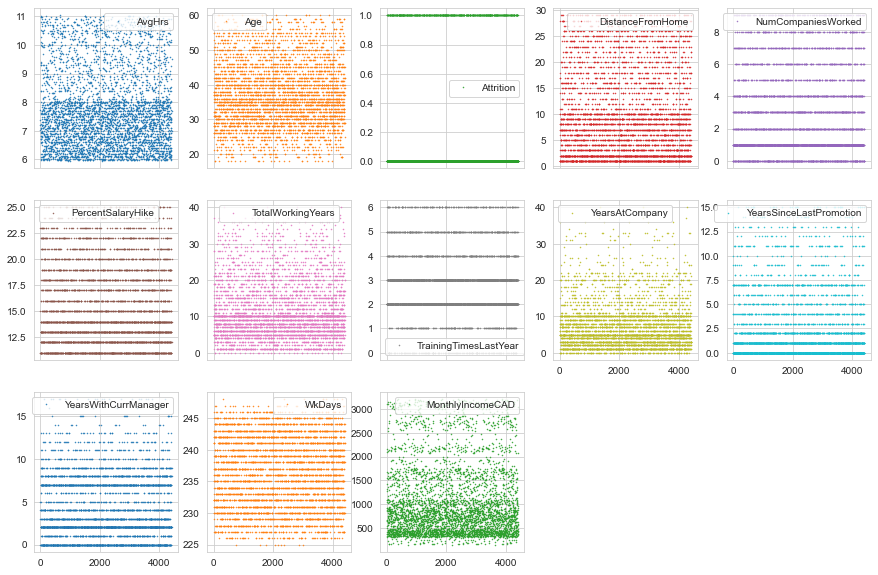

In [47]:
# Visualize the global view of all numerical variables

emp_attr.plot(marker='.', lw=0, subplots=True, layout=(-1,5), figsize=(15,10), markersize=1)

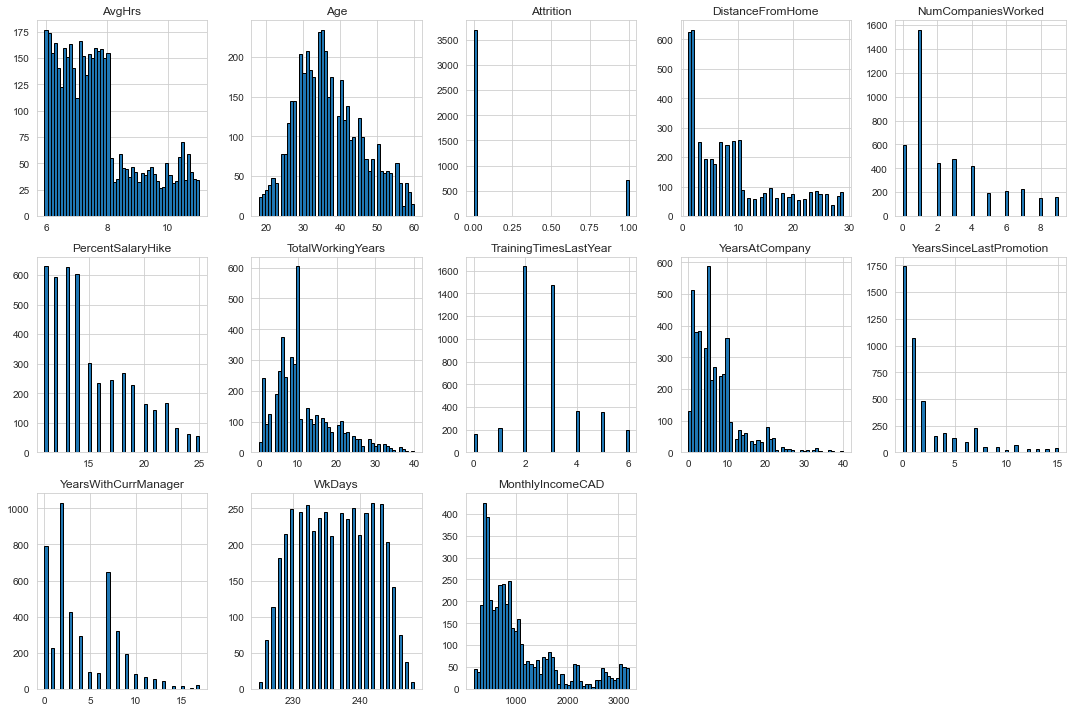

In [48]:
# Visualize the distribution of each numerical feature

emp_attr.hist(bins=50, figsize=(15,10), layout=(-1,5), edgecolor='black')
plt.tight_layout()

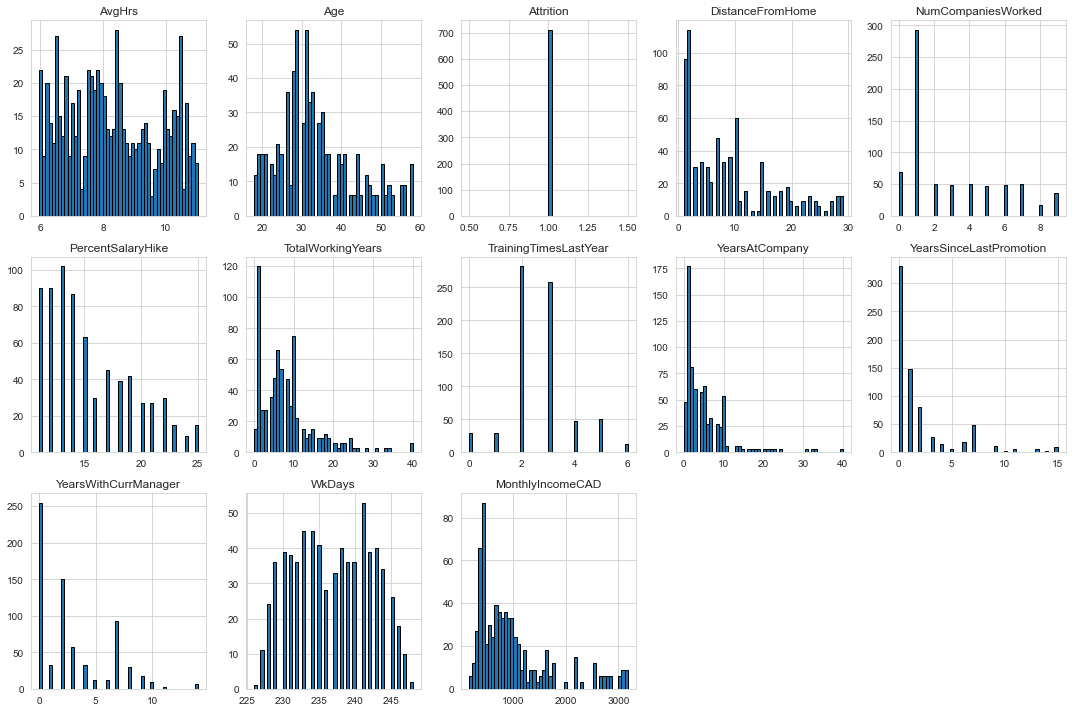

In [49]:
# Visualize the distribution of each numerical feature with Attrition equals 1

emp_attr[emp_attr['Attrition']==1].hist(bins=50, figsize=(15,10), layout=(-1,5), edgecolor='black')
plt.tight_layout()

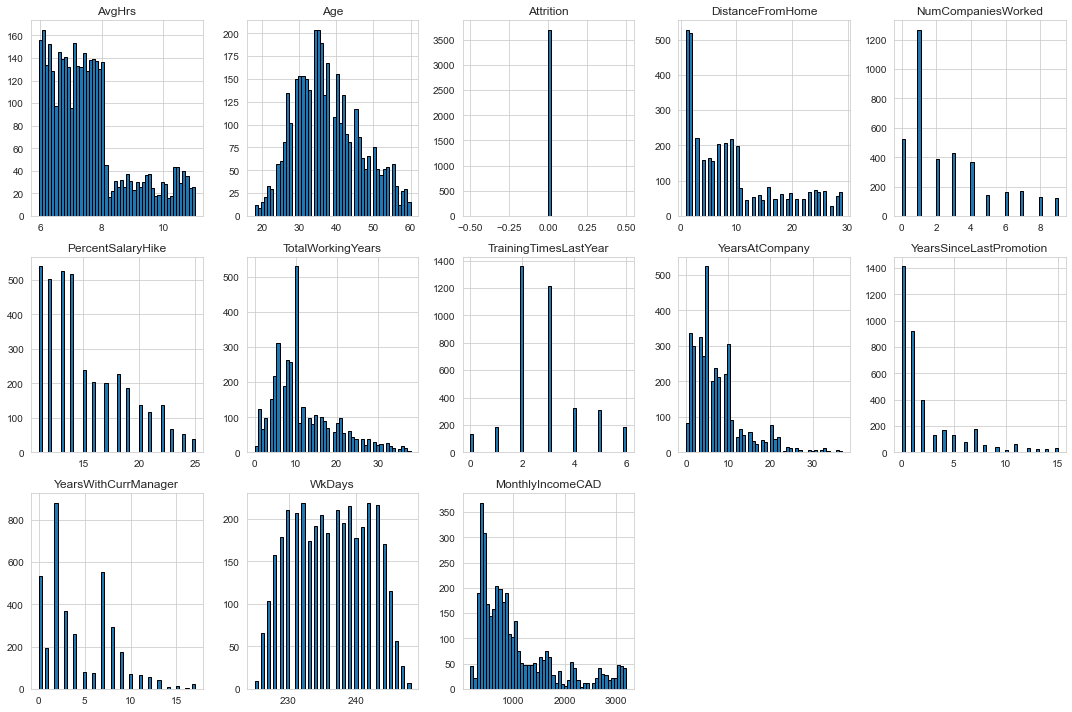

In [50]:
# Visualize the distribution of each numerical feature with Attrition equals 0

emp_attr[emp_attr['Attrition']==0].hist(bins=50, figsize=(15,10), layout=(-1,5), edgecolor='black')
plt.tight_layout()

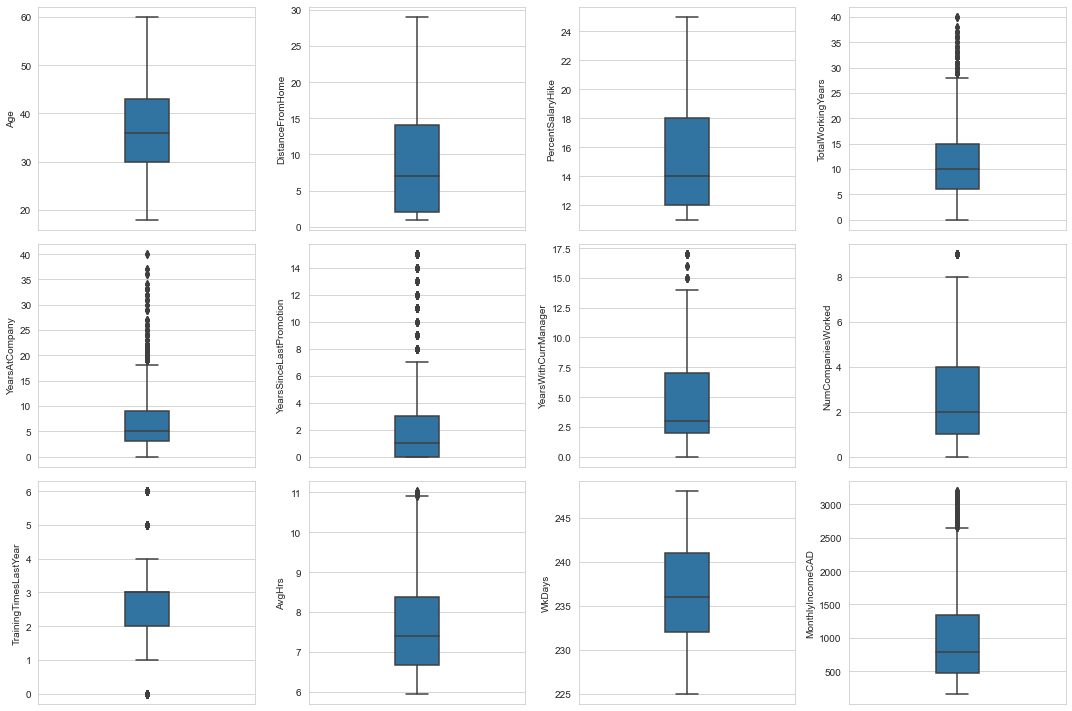

In [51]:
# Visualize the outliers of each numerical feature

variables = ['Age','DistanceFromHome','PercentSalaryHike',
             'TotalWorkingYears','YearsAtCompany','YearsSinceLastPromotion',
             'YearsWithCurrManager','NumCompaniesWorked','TrainingTimesLastYear',
             'AvgHrs','WkDays','MonthlyIncomeCAD']
fig, axes = plt.subplots(3, 4, figsize=(15,10))
for i, var in enumerate(variables):
  ax = fig.axes[i]
  sns.boxplot(y=var, width=0.2, data=emp_attr, ax=ax, showfliers=True)
plt.tight_layout()
plt.show()

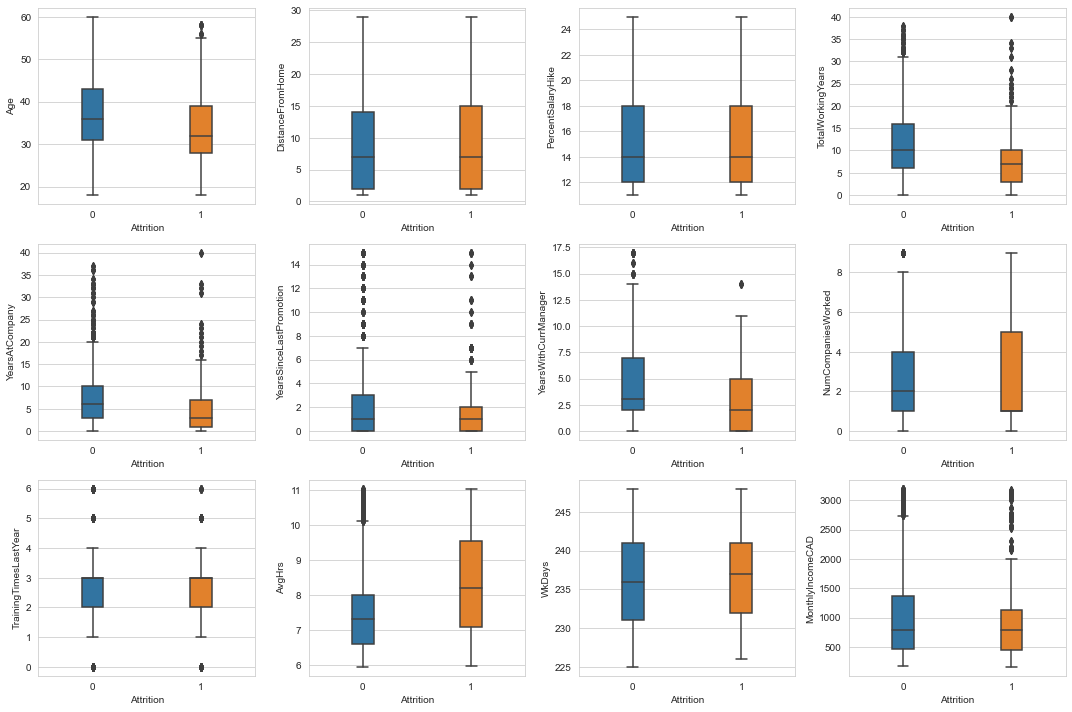

In [52]:
# Visualize the outliers of each numerical feature group by Attrition

fig, axes = plt.subplots(3, 4, figsize=(15,10))
for i, var in enumerate(variables):
  ax = fig.axes[i]
  sns.boxplot(x='Attrition', y=var, width=0.2, data=emp_attr, ax=ax, showfliers=True)
plt.tight_layout()
plt.show()

***
Findings:

Above plot shows that TotalWorkingYears, YearsAtCompany, YearsSinceLastPromotion, YearsWithCurrentManager, NumCOmpaniesWorked, TrainingTimesLastYear, AvgHrs, MonthlyIncomeCAD features have outliers. However, considering the nature of employee characteristics and the business context, we think these outliers are reasonable, and therefore treatment is unnecessary.
***

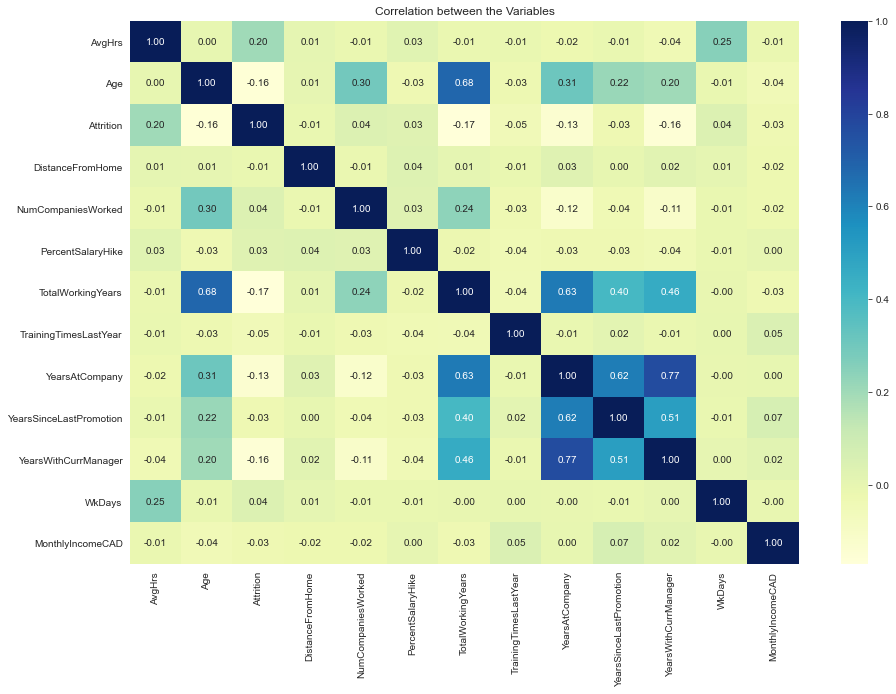

In [53]:
# Visualize the correlation between numerical variables with heatmap

plt.figure(figsize=(15,10))
with sns.axes_style('darkgrid'):
  sns.heatmap(emp_attr.corr(), cmap='YlGnBu', annot=True, fmt='.2f')
plt.title('Correlation between the Variables')
plt.show()

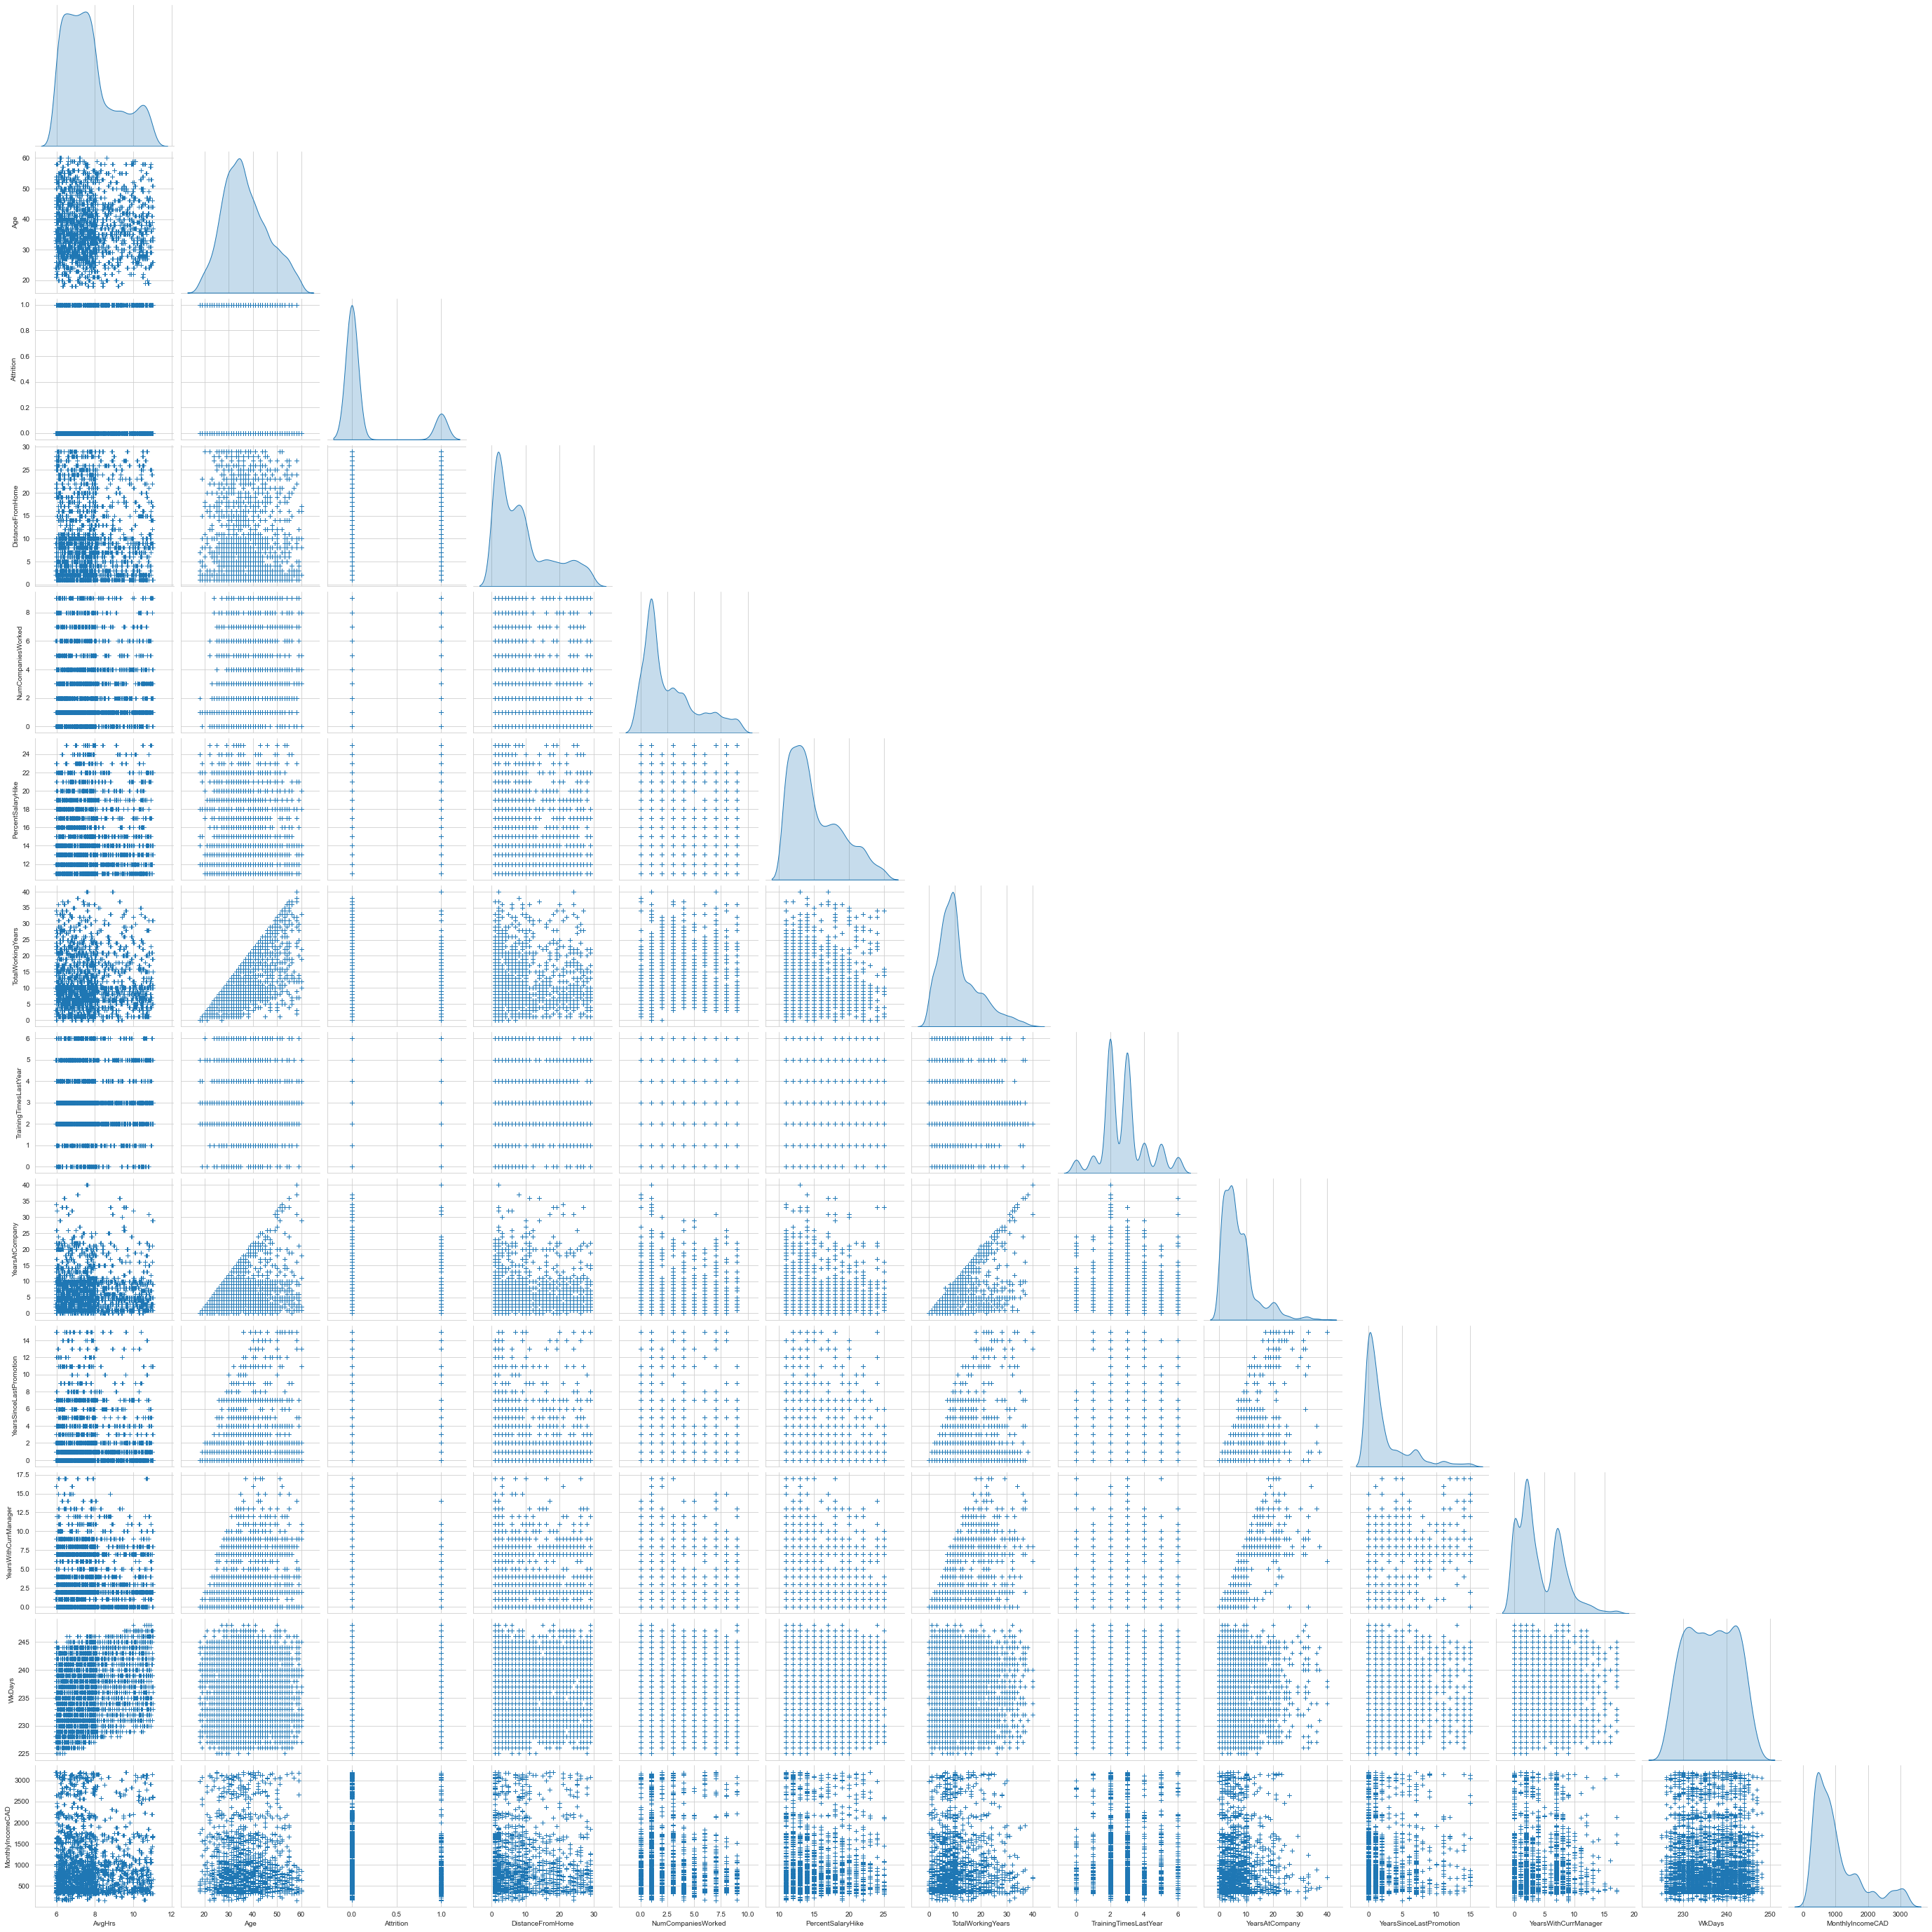

In [54]:
# Visualize the correlation between numerical variables with pairplot

sns.pairplot(emp_attr, diag_kind='kde', height=3, plot_kws=dict(marker='+', linewidth=1), corner=True)

<AxesSubplot:>

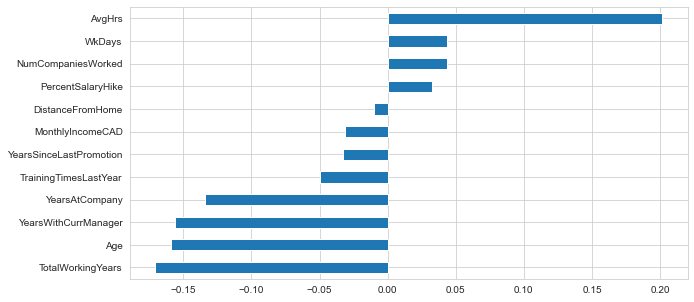

In [55]:
# Visualize the correlation between Attrition and numerical features

emp_attr.drop('Attrition', axis=1).corrwith(emp_attr.Attrition).sort_values().plot(kind='barh', figsize=(10,5))

***
Findings:

Above plot shows that YearsAtCompany and YearsWithCurrManager features are highly correlated with a correlation of 0.77. Based on an absolute correlation coefficient of >0.7, we found that there is a multicollinearity between these two features and one of them could be removed. We decided to remove YearsWithCurrManager as this feature has a higher absolute correlation coefficient with Attrition, which is -0.16, as compared to -0.13 for YearsAtCompany.
***

In [56]:
# Remove YearsWithCurrManager feature

emp_attr = emp_attr.drop('YearsWithCurrManager', axis=1)

In [57]:
emp_attr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   AvgHrs                   4410 non-null   float64 
 1   Age                      4410 non-null   int32   
 2   Attrition                4410 non-null   int32   
 3   BusinessTravel           4410 non-null   category
 4   Department               4410 non-null   category
 5   DistanceFromHome         4410 non-null   int32   
 6   Education                4410 non-null   category
 7   EducationField           4410 non-null   category
 8   Gender                   4410 non-null   category
 9   JobLevel                 4410 non-null   category
 10  JobRole                  4410 non-null   category
 11  MaritalStatus            4410 non-null   category
 12  NumCompaniesWorked       4410 non-null   int32   
 13  PercentSalaryHike        4410 non-null   int32   
 14  StockOpt

##### 2.3.1.2 Treatment for Skewness

In [58]:
# Check skewness

emp_attr.skew(axis=0, numeric_only=None).sort_values(ascending=False)

YearsSinceLastPromotion    1.982939
Attrition                  1.843111
YearsAtCompany             1.763328
MonthlyIncomeCAD           1.368885
TotalWorkingYears          1.116413
NumCompaniesWorked         1.025210
DistanceFromHome           0.957466
AvgHrs                     0.863133
PercentSalaryHike          0.820569
TrainingTimesLastYear      0.552748
Age                        0.413005
WkDays                    -0.001529
dtype: float64

***
N.B.

Initially, we plan to use Box-Cox transformation technique, but due to its inability to handle zero and negative values, we decide to apply Yeo-Johnson transformation technique to reduce skewness as it has no restriction on the value range and can also produce the most Gaussian-like distribution like Box-Cox transformation. 
***

In [59]:
# Apply Yeo-Johnson transformation to reduce skewness

sk_list = ['YearsSinceLastPromotion','MonthlyIncomeCAD','DistanceFromHome',
           'YearsAtCompany','TotalWorkingYears','NumCompaniesWorked',
           'AvgHrs','PercentSalaryHike','TrainingTimesLastYear']

pt = PowerTransformer(method='yeo-johnson')
pt.fit(emp_attr[sk_list])
sk_trans = pt.transform(emp_attr[sk_list])
columns = [i + '_Trans' for i in sk_list]
sk_trans = pd.DataFrame(sk_trans, columns=columns)
sk_trans

,YearsSinceLastPromotion_Trans,MonthlyIncomeCAD_Trans,DistanceFromHome_Trans,YearsAtCompany_Trans,TotalWorkingYears_Trans,NumCompaniesWorked_Trans,AvgHrs_Trans,PercentSalaryHike_Trans,TrainingTimesLastYear_Trans
0,-1.094862,1.354508,-0.050827,-1.440442,-1.988175,-0.571760,-0.036113,-1.488918,2.248381
1,0.096854,-0.261740,0.479509,-0.066114,-0.591832,-1.664783,0.257459,1.679689,0.217384
2,-1.094862,1.823661,1.063256,-0.066114,-0.792733,-0.571760,-0.387277,0.201133,-0.578785
3,1.454429,0.754687,-1.031215,0.482432,0.433423,0.468307,-0.205233,-1.488918,1.615639
4,-1.094862,-1.243136,0.479509,0.139692,-0.090437,0.792292,0.474517,-0.948760,-0.578785
...,...,...,...,...,...,...,...,...,...
4405,-1.094862,0.294584,-0.230523,-0.591845,0.052716,0.468307,0.812938,0.719724,1.615639
4406,-1.094862,-1.005757,-1.031215,-0.591845,0.052716,0.042902,-1.562109,0.201133,-0.578785
4407,0.096854,-0.460539,1.503182,-0.305280,-0.792733,-1.664783,0.247613,1.281630,0.942515
4408,1.454429,-1.200814,1.127721,0.628829,0.052716,-1.664783,1.310623,-0.121307,-0.578785


In [60]:
# Check the skewness of skewed features after transformation

sk_trans.skew(axis=0, numeric_only=None).sort_values(ascending=False)

YearsSinceLastPromotion_Trans    0.211985
PercentSalaryHike_Trans          0.116171
AvgHrs_Trans                     0.108956
TrainingTimesLastYear_Trans      0.058018
MonthlyIncomeCAD_Trans           0.032903
NumCompaniesWorked_Trans         0.014684
DistanceFromHome_Trans          -0.007463
YearsAtCompany_Trans            -0.008677
TotalWorkingYears_Trans         -0.010675
dtype: float64

array([[<AxesSubplot:title={'center':'YearsSinceLastPromotion_Trans'}>,
        <AxesSubplot:title={'center':'MonthlyIncomeCAD_Trans'}>,
        <AxesSubplot:title={'center':'DistanceFromHome_Trans'}>],
       [<AxesSubplot:title={'center':'YearsAtCompany_Trans'}>,
        <AxesSubplot:title={'center':'TotalWorkingYears_Trans'}>,
        <AxesSubplot:title={'center':'NumCompaniesWorked_Trans'}>],
       [<AxesSubplot:title={'center':'AvgHrs_Trans'}>,
        <AxesSubplot:title={'center':'PercentSalaryHike_Trans'}>,
        <AxesSubplot:title={'center':'TrainingTimesLastYear_Trans'}>]],
      dtype=object)

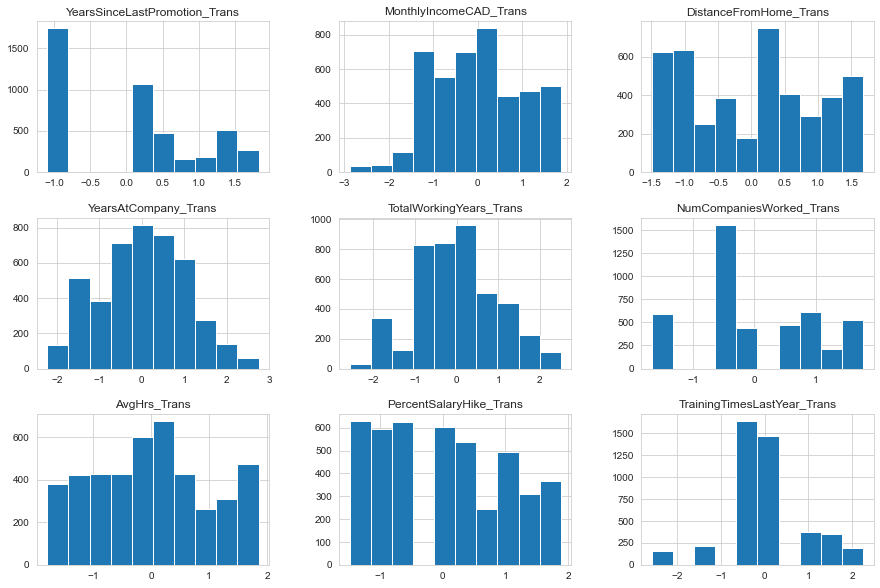

In [61]:
# Visualize the distribution of skewed features after transformation

sk_trans.hist(figsize=(15,10))

***
Findings:

Above plot shows that the skewed features have become more normally distributed after the transformation, which can help to reduce the impact of skewness in the modeling stage. 
***

In [62]:
# Concatenate the transformed features with the original dataframe

df_list = [emp_attr, sk_trans]
emp_attr_trans = pd.concat(df_list, axis=1)
emp_attr_trans

,AvgHrs,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,...,MonthlyIncomeCAD,YearsSinceLastPromotion_Trans,MonthlyIncomeCAD_Trans,DistanceFromHome_Trans,YearsAtCompany_Trans,TotalWorkingYears_Trans,NumCompaniesWorked_Trans,AvgHrs_Trans,PercentSalaryHike_Trans,TrainingTimesLastYear_Trans
0,7.373651,51,0,3,3,6,2,2,0,1,...,2098,-1.094862,1.354508,-0.050827,-1.440442,-1.988175,-0.571760,-0.036113,-1.488918,2.248381
1,7.718969,31,1,2,2,10,1,2,0,1,...,670,0.096854,-0.261740,0.479509,-0.066114,-0.591832,-1.664783,0.257459,1.679689,0.217384
2,7.013240,32,0,2,2,17,4,5,1,4,...,3092,-1.094862,1.823661,1.063256,-0.066114,-0.792733,-0.571760,-0.387277,0.201133,-0.578785
3,7.193678,38,0,1,2,2,5,2,1,3,...,1331,1.454429,0.754687,-1.031215,0.482432,0.433423,0.468307,-0.205233,-1.488918,1.615639
4,8.006175,32,0,3,2,10,1,4,1,1,...,374,-1.094862,-1.243136,0.479509,0.139692,-0.090437,0.792292,0.474517,-0.948760,-0.578785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,8.522277,42,0,3,2,5,4,4,0,1,...,964,-1.094862,0.294584,-0.230523,-0.591845,0.052716,0.468307,0.812938,0.719724,1.615639
4406,6.092954,29,0,3,2,2,4,4,1,1,...,428,-1.094862,-1.005757,-1.031215,-0.591845,0.052716,0.042902,-1.562109,0.201133,-0.578785
4407,7.706632,25,0,3,2,25,2,2,1,2,...,592,0.096854,-0.460539,1.503182,-0.305280,-0.792733,-1.664783,0.247613,1.281630,0.942515
4408,9.492595,42,0,3,3,18,2,4,1,1,...,383,1.454429,-1.200814,1.127721,0.628829,0.052716,-1.664783,1.310623,-0.121307,-0.578785


In [63]:
# Check the skewness of all the variables

emp_attr_trans.skew(axis=0, numeric_only=None).sort_index()

Age                              0.413005
Attrition                        1.843111
AvgHrs                           0.863133
AvgHrs_Trans                     0.108956
DistanceFromHome                 0.957466
DistanceFromHome_Trans          -0.007463
MonthlyIncomeCAD                 1.368885
MonthlyIncomeCAD_Trans           0.032903
NumCompaniesWorked               1.025210
NumCompaniesWorked_Trans         0.014684
PercentSalaryHike                0.820569
PercentSalaryHike_Trans          0.116171
TotalWorkingYears                1.116413
TotalWorkingYears_Trans         -0.010675
TrainingTimesLastYear            0.552748
TrainingTimesLastYear_Trans      0.058018
WkDays                          -0.001529
YearsAtCompany                   1.763328
YearsAtCompany_Trans            -0.008677
YearsSinceLastPromotion          1.982939
YearsSinceLastPromotion_Trans    0.211985
dtype: float64

In [64]:
# Check the skewness of all the features group by Attrition

emp_attr_trans.groupby('Attrition').skew(axis=0, numeric_only=None).transpose()

Attrition,0,1
AvgHrs,1.023222,0.174335
Age,0.407790,0.712699
DistanceFromHome,0.955069,0.964420
NumCompaniesWorked,1.056910,0.861796
PercentSalaryHike,0.831008,0.763693
TotalWorkingYears,1.066192,1.678789
TrainingTimesLastYear,0.556343,0.422124
YearsAtCompany,1.656612,2.670876
YearsSinceLastPromotion,1.945130,2.208164
WkDays,-0.002690,0.017011


In [65]:
# Remove the skewed numerical features from the original dataset

emp_attr_trans = emp_attr_trans.drop(sk_list,axis=1)

In [66]:
emp_attr_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Age                            4410 non-null   int32   
 1   Attrition                      4410 non-null   int32   
 2   BusinessTravel                 4410 non-null   category
 3   Department                     4410 non-null   category
 4   Education                      4410 non-null   category
 5   EducationField                 4410 non-null   category
 6   Gender                         4410 non-null   category
 7   JobLevel                       4410 non-null   category
 8   JobRole                        4410 non-null   category
 9   MaritalStatus                  4410 non-null   category
 10  StockOptionLevel               4410 non-null   category
 11  WkDays                         4410 non-null   int32   
 12  EnvironmentSatisfaction        441

##### 2.3.1.3 Additional Work

Alternatively, we treat TrainingTimesLastYear as categorical feature and apply binning technique on it to find out whether the binned feature is more significant to Attrition.

In [67]:
# Copy the original dataset to a new dataframe for testing
# Bin TrainingTimesLastYear feature into two categories

emp_attr_bin = emp_attr.copy()
emp_attr_bin['TrainingTimesLastYear_Bin'] = np.where(emp_attr_bin['TrainingTimesLastYear']<=2, '1','2')
emp_attr_bin.head()

,AvgHrs,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,WkDays,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,MonthlyIncomeCAD,TrainingTimesLastYear_Bin
0,7.373651,51,0,3,3,6,2,2,0,1,...,1,0,232,3,4,2,3,3,2098,2
1,7.718969,31,1,2,2,10,1,2,0,1,...,5,1,236,3,2,4,2,4,670,2
2,7.013240,32,0,2,2,17,4,5,1,4,...,5,0,242,2,2,1,3,3,3092,1
3,7.193678,38,0,1,2,2,5,2,1,3,...,8,7,235,4,4,3,2,3,1331,2
4,8.006175,32,0,3,2,10,1,4,1,1,...,6,0,245,4,1,3,3,3,374,1


In [68]:
# Check the importance of TrainingTimesLastYear_Bin (categorical) and 
# TrainingTimesLastYear (numerical) features with Decision Tree

X = emp_attr_bin.drop(columns=['Attrition'])
y = emp_attr_bin.Attrition

clf = DecisionTreeClassifier(random_state=11)
clf.fit(X,y)

DecisionTreeClassifier(random_state=11)

In [69]:
# Check the importance of each feature

importance = clf.feature_importances_
df = pd.DataFrame({'feature':X.columns,'importance':importance})
print(df.sort_values('importance', ascending=False))

                      feature  importance
0                      AvgHrs    0.145151
24           MonthlyIncomeCAD    0.092236
14          TotalWorkingYears    0.092000
1                         Age    0.081329
19    EnvironmentSatisfaction    0.063905
21            WorkLifeBalance    0.047500
12          PercentSalaryHike    0.043683
11         NumCompaniesWorked    0.043171
4            DistanceFromHome    0.041530
16             YearsAtCompany    0.039158
10              MaritalStatus    0.037869
5                   Education    0.035871
13           StockOptionLevel    0.033513
9                     JobRole    0.027099
6              EducationField    0.025945
20            JobSatisfaction    0.023889
7                      Gender    0.022075
3                  Department    0.020587
22             JobInvolvement    0.018310
15      TrainingTimesLastYear    0.018049
17    YearsSinceLastPromotion    0.016598
8                    JobLevel    0.014602
25  TrainingTimesLastYear_Bin    0

***
Findings:

Above result shows that the TrainingTimesLastYear_Bin is less significant than TrainingTimesLastYear to Attrition. Therefore, we decide to keep TrainingTimesLastYear as numerical feature.
***

#### 2.3.2 Categorical Features

##### 2.3.2.1 Features Description

In [70]:
# View statistics summary of categorical features

emp_attr.describe(exclude='number').transpose()

,count,unique,top,freq
BusinessTravel,4410,3,3,3129
Department,4410,3,2,2883
Education,4410,5,3,1716
EducationField,4410,6,2,1818
Gender,4410,2,1,2646
JobLevel,4410,5,1,1629
JobRole,4410,9,8,978
MaritalStatus,4410,3,2,2019
StockOptionLevel,4410,4,0,1893
EnvironmentSatisfaction,4410,4,3,1360


<ipython-input-71-c9a9ebf759c5>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


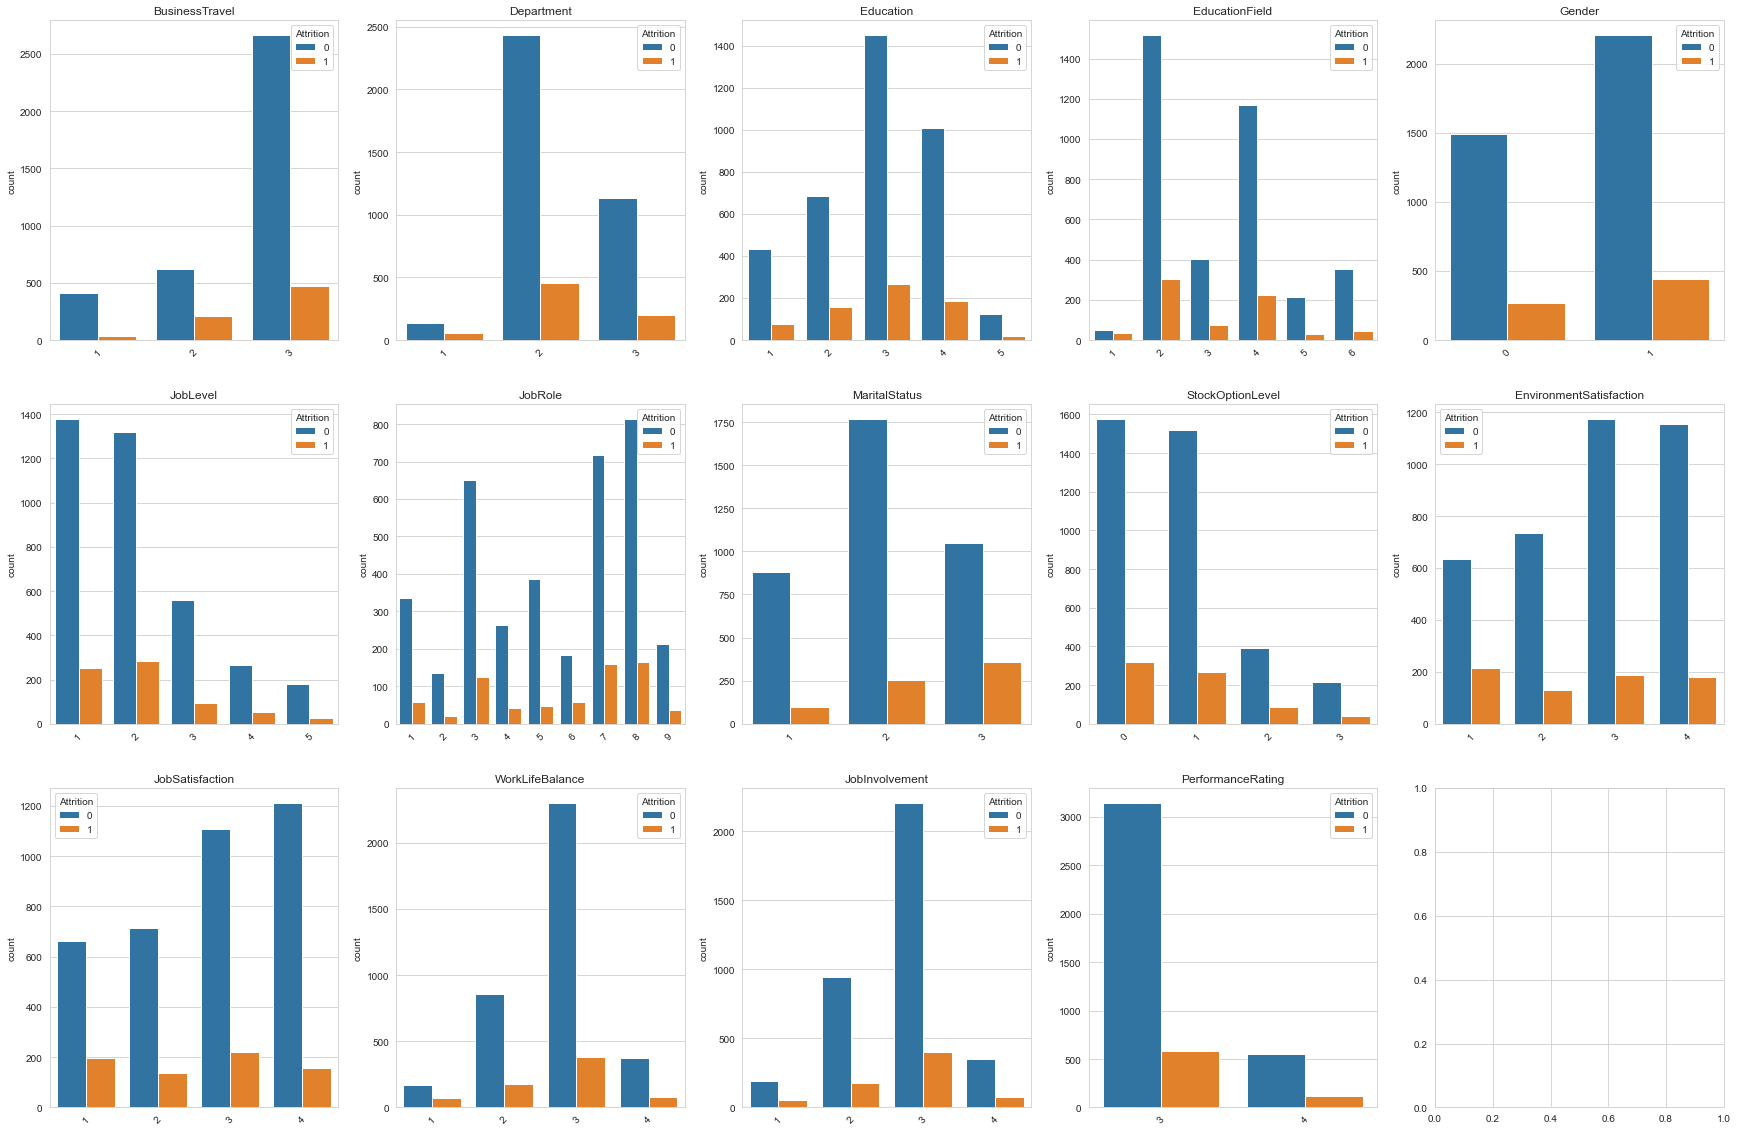

In [71]:
# Visualize categorical features

categorical_features = emp_attr.describe(exclude='number').columns.tolist()
fig, ax = plt.subplots(3, 5, figsize=(30,20))
for i, var in enumerate(categorical_features):
  ax = fig.axes[i]
  sns.countplot(x=var, hue='Attrition', ax=ax, data=emp_attr).set(title=var, xlabel=None)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
fig.show()

##### 2.3.2.2 Correlation

In [72]:
# Check correlation between categorical features and Attrition

for i, var in enumerate(categorical_features):
  crosstab_result=pd.crosstab(index=emp_attr[var], columns=emp_attr['Attrition'])
  print(crosstab_result)

  # Perform Chi-squared test
  ChiSqResult = chi2_contingency(crosstab_result)
  
  print('The P-Value of the Chi-Squared Test is: {:.30f}'.format(ChiSqResult[1]),
        '\n','************************************************************************','\n')

Attrition          0    1
BusinessTravel           
1                414   36
2                624  207
3               2661  468
The P-Value of the Chi-Squared Test is: 0.000000000000000176427697298319 
 ************************************************************************ 

Attrition      0    1
Department           
1            132   57
2           2430  453
3           1137  201
The P-Value of the Chi-Squared Test is: 0.000000482088821817040684207208 
 ************************************************************************ 

Attrition     0    1
Education           
1           432   78
2           687  159
3          1449  267
4          1008  186
5           123   21
The P-Value of the Chi-Squared Test is: 0.227598263017823931875227572164 
 ************************************************************************ 

Attrition          0    1
EducationField           
1                 48   33
2               1515  303
3                402   75
4               1167  225
5      

***
Findings:

P-value less than 0.05 indicates a statistical significance. 

Above result shows that BusinessTravel, Department, EducationField, JobRole, MaritalStatus, EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance, JobInvolvement features are statistically significant to Attrition.
***

# 3.0 Modeling

The objectives of this section are to:

1. Identify the key factors that may cause employees to leave the company, and

2. Predict whether an employee will leave the company.

To achieve the above objectives, we will be using the five models: Decision Tree, Random Forest, Naive Bayes, Logistic Regression, and K-Nearest Neighbors. 


In [73]:
# Function to encode categorical features

def getDummies(dataframe, dropfirst):
  
  encodevar = pd.get_dummies(dataframe, drop_first=dropfirst)
  return encodevar

In [74]:
# Function to standardize features by using MinMaxScaler
# MinMaxScaler: values are scaled in the range between 0 and 1

def scaling(feature):
  
  scaler = MinMaxScaler()
  scalevar = pd.DataFrame(scaler.fit_transform(feature), columns=feature.columns)
  return scalevar

In [75]:
# Function to display classification metrics

def summary(modelname, model, target_train, feature_train, target, feature):
  
  print("Train classification summary:")
  classificationSummary(target_train, model.predict(feature_train))
  print("--------------------------------------------------------------------------")
  print("\nTest classification summary:")
  classificationSummary(target, model.predict(feature))

  print("\nPrecision Score: ", round(precision_score(target, model.predict(feature)), 8))
  print("Recall Score: ", round(recall_score(target, model.predict(feature)), 8))
  print("F1 Score: ", round(f1_score(target, model.predict(feature)), 8))

  fpr = 'fpr_' + modelname
  tpr = 'tpr_' + modelname
  auc = 'auc_' + modelname 
  globals()[fpr], globals()[tpr], _ = metrics.roc_curve(target, model.predict_proba(feature)[:,1])
  globals()[auc] = round(metrics.roc_auc_score(target, model.predict_proba(feature)[:,1]), 8)

In [76]:
# Function to oversample the minority class (Attrition == 1) with SMOTE
# And undersample the majority class (Attrition == 0) with RandomUnderSampler class

def sampling(feature, target, isCat):
  
  # Visualize the Attrition in training set
  colors = ['#66b3ff','#ff9999']
  explode = (0.05, 0.05)
  plt.figure(figsize=(5, 5))
  plt.pie(pd.Series(target).value_counts(), colors=colors, labels=['No','Yes'], 
          autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
  plt.legend()
  plt.title('Targets in Training Set')
  plt.show()

  print(feature.shape)

  # Oversample and Undersample
  if isCat == True:
    oversampler = SMOTENC(categorical_features=[feature.columns.get_loc(c) for c in cat_list],
                          random_state=1)
  else:
    oversampler = SMOTE(random_state=1)
  undersampler = RandomUnderSampler(random_state=1)
  steps = [('o',oversampler), ('u',undersampler)]
  pipeline = Pipeline(steps=steps)
  sampled_X, sampled_y = pipeline.fit_resample(feature, target)

  # Visualize the Attrition in training set after sampling
  colors = ['#66b3ff','#ff9999']
  explode = (0.05, 0.05)
  plt.figure(figsize=(5, 5))
  plt.pie(pd.Series(sampled_y).value_counts(), colors=colors, labels=['No','Yes'], 
        autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
  plt.legend()
  plt.title('Sampled Targets in Training Set')
  plt.show()

  print(sampled_X.shape)

  return sampled_X, sampled_y

In [77]:
# Duplicate the datasets for each model

emp_attr_dt = emp_attr.copy()
emp_attr_dt_trans = emp_attr_trans.copy()
emp_attr_rf_trans = emp_attr_trans.copy()
emp_attr_nb = emp_attr_trans.copy()
emp_attr_lr = emp_attr_trans.copy()
emp_attr_knn = emp_attr_trans.copy()

### 3.1 Decision Tree

#### 3.1.1 Decision Tree without Sampling

In [78]:
emp_attr_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   AvgHrs                   4410 non-null   float64 
 1   Age                      4410 non-null   int32   
 2   Attrition                4410 non-null   int32   
 3   BusinessTravel           4410 non-null   category
 4   Department               4410 non-null   category
 5   DistanceFromHome         4410 non-null   int32   
 6   Education                4410 non-null   category
 7   EducationField           4410 non-null   category
 8   Gender                   4410 non-null   category
 9   JobLevel                 4410 non-null   category
 10  JobRole                  4410 non-null   category
 11  MaritalStatus            4410 non-null   category
 12  NumCompaniesWorked       4410 non-null   int32   
 13  PercentSalaryHike        4410 non-null   int32   
 14  StockOpt

In [79]:
# Split the data into Train (70%) and Test (30%)

X = emp_attr_dt.drop(columns=['Attrition'])
y = emp_attr_dt['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [80]:
print(X_train.shape)
print(X_test.shape)

(3087, 25)
(1323, 25)


In [81]:
# Run Decision Tree modeling

dt_wt_cv = DecisionTreeClassifier(random_state=1)
dt_wt_cv.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [82]:
# Check the importance of each feature

importance = dt_wt_cv.feature_importances_
df = pd.DataFrame({'feature':X_train.columns,'importance':importance})
print(df.sort_values('importance', ascending=False))

                    feature  importance
0                    AvgHrs    0.163589
14        TotalWorkingYears    0.115153
24         MonthlyIncomeCAD    0.093563
1                       Age    0.060505
17  YearsSinceLastPromotion    0.055793
4          DistanceFromHome    0.053385
20          JobSatisfaction    0.047453
10            MaritalStatus    0.042310
16           YearsAtCompany    0.041543
6            EducationField    0.041273
11       NumCompaniesWorked    0.035667
3                Department    0.031665
21          WorkLifeBalance    0.027870
19  EnvironmentSatisfaction    0.027206
15    TrainingTimesLastYear    0.026631
9                   JobRole    0.024512
7                    Gender    0.023745
12        PercentSalaryHike    0.018279
13         StockOptionLevel    0.017959
5                 Education    0.016986
22           JobInvolvement    0.011850
2            BusinessTravel    0.008549
8                  JobLevel    0.007654
18                   WkDays    0.006859


***
Findings:

From the above analysis on features importance, AvgHrs is the most significant feature in predicting the employee attrition, followed by TotalWorkingYears and MonthlyIncomeCAD.
***

In [83]:
# Visualize the Decision Tree

plotDecisionTree(dt_wt_cv, feature_names=X_train.columns)

'You need to install pydotplus to visualize decision trees'

In [84]:
# Display classification summary and accuracy

summary('dt_wt_cv', dt_wt_cv, y_train, X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2589    0
     1    0  498
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.9615)

       Prediction
Actual    0    1
     0 1087   23
     1   28  185

Precision Score:  0.88942308
Recall Score:  0.8685446
F1 Score:  0.87885986


#### 3.1.2 Decision Tree with Sampling

In order to prevent bias in our modelling towards predictions and to be more accurate in predicting both the majority and the minority classes, we need to handle the data imbalanced issue in our dataset.

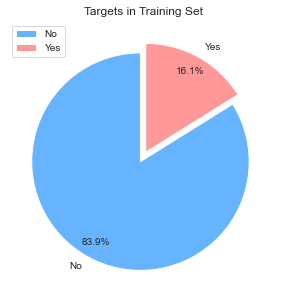

(3087, 25)


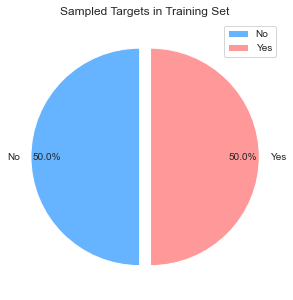

(5178, 25)


In [85]:
# Oversample the minority class and undersample the majority class

sampled_X_train, sampled_y_train = sampling(X_train, y_train, True)

In [86]:
# Run Decision Tree modeling

dt_s_wt_cv = DecisionTreeClassifier(random_state=1)
dt_s_wt_cv.fit(sampled_X_train, sampled_y_train)

DecisionTreeClassifier(random_state=1)

In [87]:
# Check the importance of each feature

importance = dt_s_wt_cv.feature_importances_
df = pd.DataFrame({'feature':sampled_X_train.columns,'importance':importance})
print(df.sort_values('importance', ascending=False))

                    feature  importance
0                    AvgHrs    0.138322
24         MonthlyIncomeCAD    0.117096
14        TotalWorkingYears    0.101649
16           YearsAtCompany    0.070996
1                       Age    0.060478
19  EnvironmentSatisfaction    0.060056
10            MaritalStatus    0.056104
4          DistanceFromHome    0.044725
12        PercentSalaryHike    0.039741
15    TrainingTimesLastYear    0.036815
7                    Gender    0.030511
9                   JobRole    0.025692
2            BusinessTravel    0.024548
22           JobInvolvement    0.024512
18                   WkDays    0.022296
11       NumCompaniesWorked    0.019200
20          JobSatisfaction    0.019116
17  YearsSinceLastPromotion    0.018288
13         StockOptionLevel    0.016981
5                 Education    0.016673
21          WorkLifeBalance    0.014659
23        PerformanceRating    0.012820
6            EducationField    0.012695
8                  JobLevel    0.008855


***
Findings:

From the above analysis on features importance, AvgHrs is the most significant feature in predicting the employee attrition, followed by MonthlyIncomeCAD and TotalWorkingYears.
***

In [88]:
# Visualize the Decision Tree

plotDecisionTree(dt_s_wt_cv, feature_names=sampled_X_train.columns)

'You need to install pydotplus to visualize decision trees'

In [89]:
# Display a classification summary and accuracy

summary('dt_s_wt_cv', dt_s_wt_cv, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2589    0
     1    0 2589
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.9456)

       Prediction
Actual    0    1
     0 1067   43
     1   29  184

Precision Score:  0.81057269
Recall Score:  0.86384977
F1 Score:  0.83636364


##### 3.1.2.1 RandomizedSearchCV

In [90]:
# Set hyperparameters 

params_dt = {'max_depth':np.arange(1,20),
             'min_samples_leaf':np.arange(1,10),
             'min_samples_split':np.arange(2,10)}

In [91]:
# Use RandomizedSearchCV to select the best hyperparameters for optimal tree
# Run Decision Tree modeling

rs = RandomizedSearchCV(DecisionTreeClassifier(random_state=1), 
                        param_distributions=params_dt,
                        n_iter=200, scoring="accuracy", random_state=1,
                        n_jobs=-1, cv=10, return_train_score=True)
rs.fit(sampled_X_train,sampled_y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
                   random_state=1, return_train_score=True, scoring='accuracy')

In [92]:
# Display the optimal parameters

dt_s_w_rs = rs.best_estimator_
dt_s_w_rs

DecisionTreeClassifier(max_depth=18, random_state=1)

In [93]:
# Display classification summary and accuracy

summary('dt_s_w_rs', dt_s_w_rs, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 0.9992)

       Prediction
Actual    0    1
     0 2586    3
     1    1 2588
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.9327)

       Prediction
Actual    0    1
     0 1053   57
     1   32  181

Precision Score:  0.7605042
Recall Score:  0.84976526
F1 Score:  0.80266075


##### 3.1.2.2 AdaBoostClassifier

In [94]:
# Use AdaBoostClassifier to boost the performance of Decision Tree modeling
# Run AdaBoostClassifier 

dt_s_boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=1),
                                n_estimators=100, random_state=1)
dt_s_boost.fit(sampled_X_train, sampled_y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                   n_estimators=100, random_state=1)

In [95]:
# Display classification summary and accuracy

summary('dt_s_boost', dt_s_boost, sampled_y_train, sampled_X_train, y_test, X_test)  

Train classification summary:
Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2589    0
     1    0 2589
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.9395)

       Prediction
Actual    0    1
     0 1065   45
     1   35  178

Precision Score:  0.79820628
Recall Score:  0.83568075
F1 Score:  0.81651376


##### 3.1.2.3 BaggingClassifier

In [96]:
# Use BaggingClassifier to boost the performance of Decision Tree modeling
# Run BaggingClassifier 

dt_s_bag = BaggingClassifier(DecisionTreeClassifier(random_state=1),
                             n_estimators=100, random_state=1)
dt_s_bag.fit(sampled_X_train,sampled_y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                  n_estimators=100, random_state=1)

In [97]:
# Display classification summary and accuracy

summary('dt_s_bag', dt_s_bag, sampled_y_train, sampled_X_train, y_test, X_test)  

Train classification summary:
Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2589    0
     1    0 2589
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.9743)

       Prediction
Actual    0    1
     0 1096   14
     1   20  193

Precision Score:  0.93236715
Recall Score:  0.90610329
F1 Score:  0.91904762


#### 3.1.3 Additional Works

##### 3.1.3.1 GridSearchCV

In [98]:
# Use GridSearchCV to select the best hyperparameters for optimal tree
# Run Decision Tree modeling

gs = GridSearchCV(DecisionTreeClassifier(random_state=1), params_dt, n_jobs=-1, cv=10)
gs.fit(sampled_X_train, sampled_y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])})

In [99]:
# Display the optimal parameters

dt_s_w_cv = gs.best_estimator_
dt_s_w_cv

DecisionTreeClassifier(max_depth=18, random_state=1)

In [100]:
# Display classification summary and accuracy

summary('dt_s_w_cv', dt_s_w_cv, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 0.9992)

       Prediction
Actual    0    1
     0 2586    3
     1    1 2588
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.9327)

       Prediction
Actual    0    1
     0 1053   57
     1   32  181

Precision Score:  0.7605042
Recall Score:  0.84976526
F1 Score:  0.80266075


##### 3.1.3.2 RandomizedSearchCV with AdaBoostClassifier 

In [101]:
# Use AdaBoostClassifier to boost the performance of Decision Tree modeling

boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                           n_estimators=100, random_state=1)

In [102]:
# Set hyperparameters

params_dt_en = {'base_estimator__max_depth':np.arange(1,20),
                'base_estimator__min_samples_leaf':np.arange(1,10),
                'base_estimator__min_samples_split':np.arange(2,10)}

In [103]:
# Use RandomizedSearchCV to select the best hyperparameters for optimal tree
# Run Decision Tree modeling

rs = RandomizedSearchCV(boost, params_dt_en,
                        n_iter=200, scoring="accuracy", random_state=1,
                        n_jobs=-1, cv=10, return_train_score=True)
rs.fit(sampled_X_train, sampled_y_train)

RandomizedSearchCV(cv=10,
                   estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                                                n_estimators=100,
                                                random_state=1),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'base_estimator__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'base_estimator__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'base_estimator__min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
                   random_state=1, return_train_score=True, scoring='accuracy')

In [104]:
# Display the optimal parameters

dt_s_w_rs_boost = rs.best_estimator_
dt_s_w_rs_boost

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=14,
                                                         min_samples_split=3,
                                                         random_state=1),
                   n_estimators=100, random_state=1)

In [105]:
# Display classification summary and accuracy

summary('dt_s_w_rs_boost', dt_s_w_rs_boost, sampled_y_train, sampled_X_train, y_test, X_test)  

Train classification summary:
Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2589    0
     1    0 2589
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.9879)

       Prediction
Actual    0    1
     0 1109    1
     1   15  198

Precision Score:  0.99497487
Recall Score:  0.92957746
F1 Score:  0.96116505


##### 3.1.3.3 RandomizedSearchCV with BaggingClassifier

In [106]:
# Use BaggingClassifier to boost the performance of Decision Tree modeling

bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                        n_estimators=100, random_state=1)

In [107]:
# Use RandomizedSearchCV to select the best hyperparameters for optimal tree
# Run Decision Tree modeling

rs = RandomizedSearchCV(bag, params_dt_en,
                        n_iter=200, scoring="accuracy", random_state=1,
                        n_jobs=-1, cv=10, return_train_score=True)
rs.fit(sampled_X_train,sampled_y_train)

RandomizedSearchCV(cv=10,
                   estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                                               n_estimators=100,
                                               random_state=1),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'base_estimator__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'base_estimator__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'base_estimator__min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
                   random_state=1, return_train_score=True, scoring='accuracy')

In [108]:
# Display the optimal parameters

dt_s_w_rs_bag = rs.best_estimator_
dt_s_w_rs_bag

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=18,
                                                        random_state=1),
                  n_estimators=100, random_state=1)

In [109]:
# Display classification summary and accuracy

summary('dt_s_w_rs_bag', dt_s_w_rs_bag, sampled_y_train, sampled_X_train, y_test, X_test)  

Train classification summary:
Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2589    0
     1    0 2589
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.9743)

       Prediction
Actual    0    1
     0 1097   13
     1   21  192

Precision Score:  0.93658537
Recall Score:  0.90140845
F1 Score:  0.91866029


### 3.2 Random Forest

#### 3.2.1 Random Forest without sampling

In [110]:
# Run Random Forest modeling

rf_wt_cv = RandomForestClassifier(random_state=1, n_estimators=500)
rf_wt_cv.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

In [111]:
# Check the importance of each feature

feature_imp = pd.Series(rf_wt_cv.feature_importances_,
                        index= X_train.columns).sort_values(ascending=False)
feature_imp

AvgHrs                     0.124762
Age                        0.081285
TotalWorkingYears          0.077865
MonthlyIncomeCAD           0.071483
YearsAtCompany             0.064092
DistanceFromHome           0.049394
PercentSalaryHike          0.043219
NumCompaniesWorked         0.042526
EnvironmentSatisfaction    0.038894
JobRole                    0.037283
MaritalStatus              0.034589
YearsSinceLastPromotion    0.034012
JobSatisfaction            0.031748
WorkLifeBalance            0.030631
TrainingTimesLastYear      0.028125
EducationField             0.027618
Education                  0.026929
WkDays                     0.025918
JobLevel                   0.025327
JobInvolvement             0.023510
StockOptionLevel           0.023298
BusinessTravel             0.018608
Department                 0.018551
Gender                     0.014124
PerformanceRating          0.006207
dtype: float64

***
Findings:

From the above analysis on features importance, AvgHrs is the most significant feature in predicting the employee attrition, followed by Age and TotalWorkingYears.
***

Text(0.5, 1.0, 'Visualizing Important Features')

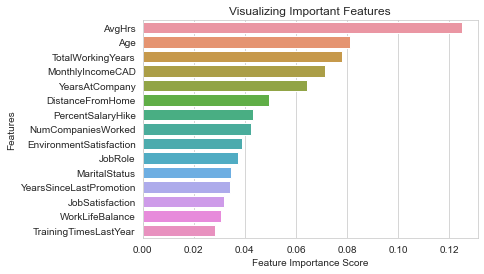

In [112]:
# Visualize the importance of top 15 features

feature_imp_top = feature_imp.head(15)

sns.barplot(x=feature_imp_top, y=feature_imp_top.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [113]:
# Display classification summary and accuracy

summary('rf_wt_cv', rf_wt_cv, y_train, X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2589    0
     1    0  498
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.9841)

       Prediction
Actual    0    1
     0 1110    0
     1   21  192

Precision Score:  1.0
Recall Score:  0.90140845
F1 Score:  0.94814815


#### 3.2.2 Random Forest with sampling

In [114]:
# Run Random Forest modeling

rf_s_wt_cv = RandomForestClassifier(random_state=1, n_estimators=500)
rf_s_wt_cv.fit(sampled_X_train, sampled_y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

In [115]:
# Check the importance of each feature

feature_imp = pd.Series(rf_s_wt_cv.feature_importances_,
                        index=sampled_X_train.columns).sort_values(ascending=False)
feature_imp

AvgHrs                     0.132259
MonthlyIncomeCAD           0.081786
Age                        0.079374
TotalWorkingYears          0.072839
YearsAtCompany             0.070197
MaritalStatus              0.053771
DistanceFromHome           0.049609
TrainingTimesLastYear      0.046643
EnvironmentSatisfaction    0.038154
PercentSalaryHike          0.036001
JobRole                    0.032821
NumCompaniesWorked         0.032772
JobSatisfaction            0.032661
WkDays                     0.029969
YearsSinceLastPromotion    0.028748
EducationField             0.025067
BusinessTravel             0.021396
Education                  0.021337
JobLevel                   0.021127
WorkLifeBalance            0.020202
JobInvolvement             0.019808
StockOptionLevel           0.019323
Department                 0.013555
Gender                     0.012441
PerformanceRating          0.008140
dtype: float64

***
Findings:

From the above analysis on features importance, AvgHrs is the most significant feature in predicting the employee attrition, followed by MonthlyIncomeCAD and Age.
***

Text(0.5, 1.0, 'Visualizing Important Features')

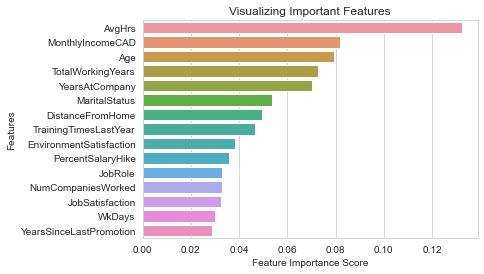

In [116]:
# Visualize the importance of top 15 features

feature_imp_top = feature_imp.head(15)

sns.barplot(x=feature_imp_top, y=feature_imp_top.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [117]:
# Display classification summary and accuracy

summary('rf_s_wt_cv', rf_s_wt_cv, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2589    0
     1    0 2589
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.9849)

       Prediction
Actual    0    1
     0 1107    3
     1   17  196

Precision Score:  0.98492462
Recall Score:  0.92018779
F1 Score:  0.95145631


In [118]:
# Interpret Random Forest using SHAP values

In [119]:
emp_attr_shap = emp_attr.copy()

In [120]:
emp_attr_shap[cat_list] = emp_attr_shap[cat_list].astype('int')

In [121]:
X_shap = emp_attr_shap.drop(columns=['Attrition'])
y_shap = emp_attr_shap['Attrition']
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(X_shap, y_shap, test_size=0.3, stratify=y_shap, random_state=1)

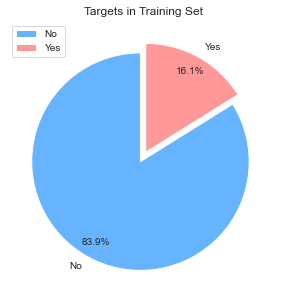

(3087, 25)


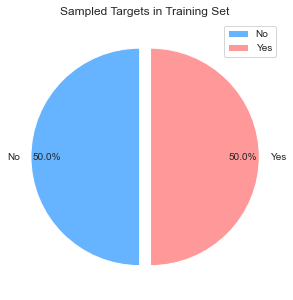

(5178, 25)


In [122]:
sampled_X_train_shap, sampled_y_train_shap = sampling(X_train_shap, y_train_shap, True)

In [123]:
rf_s_wt_cv_shap = RandomForestClassifier(random_state=1, n_estimators=500)
rf_s_wt_cv_shap.fit(sampled_X_train_shap, sampled_y_train_shap)

RandomForestClassifier(n_estimators=500, random_state=1)

In [126]:
# Calculate SHAP (SHapley Additive exPlanations) values to show the positive or negative correlation between features and Attirtion

shap.initjs() 
shap_values = shap.TreeExplainer(rf_s_wt_cv_shap).shap_values(X_test_shap)

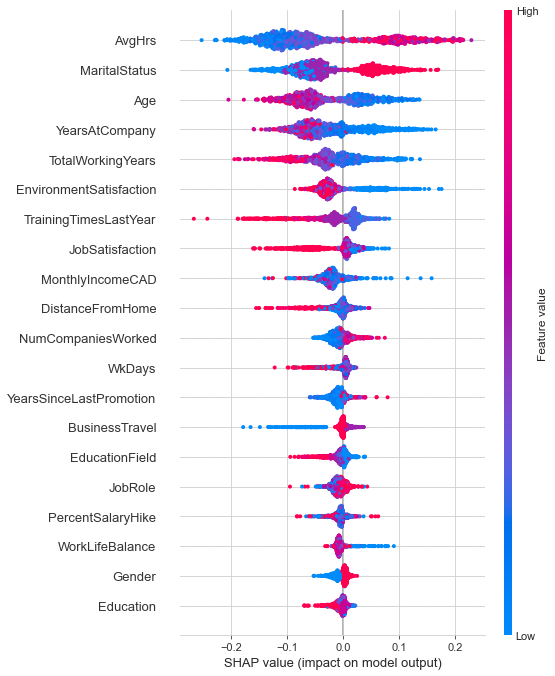

In [127]:
# Visualize the SHAP values

shap.summary_plot(shap_values[1], X_test_shap)

***

Finding:
Employees are more likely to leave the company if they:
1. work longer hours per day
2. are single
3. are younger or have fewer years at the company or fewer total working years
4. are less satisfied with the working environment 
5. have less training times
6. have lower monthly income or percent salary hike
7. have shorter distance from home
***

##### 3.2.2.1 RandomizedSearchCV

In [128]:
# Set hyperparameters

params_rf = {'n_estimators': [200,250],
             'max_depth':np.arange(1,20),
             'min_samples_leaf':np.arange(1,20),
             'min_samples_split':np.arange(2,20)}

In [129]:
# Use RandomizedSearchCV to select the best hyperparameters for optimal forest
# Run Random Forest modeling

rs = RandomizedSearchCV(RandomForestClassifier(random_state=1), 
                        param_distributions=params_rf,
                        n_iter=200, scoring="accuracy", random_state=1,
                        n_jobs=-1, cv=10, return_train_score=True)
rs.fit(sampled_X_train, sampled_y_train)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=1),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'n_estimators': [200, 250]},
                   random_state=1, return_train_score=True, scoring='accuracy')

In [130]:
# Display the optimal parameters

rf_s_w_rs = rs.best_estimator_
rf_s_w_rs

RandomForestClassifier(max_depth=14, min_samples_split=3, n_estimators=200,
                       random_state=1)

In [131]:
# Display classification summary and accuracy

summary('rf_s_w_rs', rf_s_w_rs, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 0.9996)

       Prediction
Actual    0    1
     0 2588    1
     1    1 2588
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.9796)

       Prediction
Actual    0    1
     0 1101    9
     1   18  195

Precision Score:  0.95588235
Recall Score:  0.91549296
F1 Score:  0.9352518


### 3.3 Naive Bayes

#### 3.3.1 Multinomial Naive Bayes (only categorical features)

In [132]:
# Encode categorical features

emp_attr_nb_encode = getDummies(emp_attr_nb, False)

In [133]:
# Split the data into Train (70%) and Test (30%)

X = emp_attr_nb_encode.drop(columns=['Attrition'])
y = emp_attr_nb_encode['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

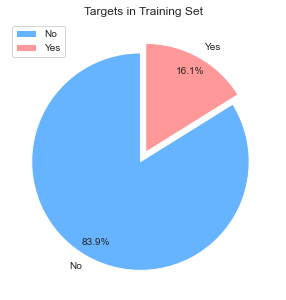

(3087, 69)


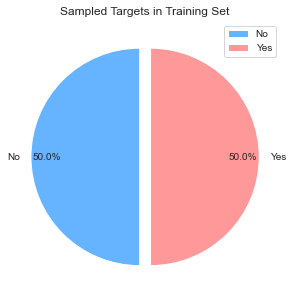

(5178, 69)


In [134]:
# Oversample the minority class and undersample the majority class

sampled_X_train, sampled_y_train = sampling(X_train, y_train, False)

In [135]:
# Extract only the encoded categorical features

encode_list = emp_attr_nb_encode.loc[:,emp_attr_nb_encode.dtypes==np.uint8].columns
sampled_X_train = sampled_X_train[encode_list]
X_test = X_test[encode_list]

In [136]:
# Run Naive Bayes (Multinomial) modeling

mnb_s = MultinomialNB(alpha=0.01)
mnb_s.fit(sampled_X_train, sampled_y_train)

MultinomialNB(alpha=0.01)

In [137]:
# Display classification summary and accuracy

summary('mnb_s', mnb_s, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 0.7607)

       Prediction
Actual    0    1
     0 1997  592
     1  647 1942
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.7181)

       Prediction
Actual   0   1
     0 846 264
     1 109 104

Precision Score:  0.2826087
Recall Score:  0.48826291
F1 Score:  0.35800344


In [138]:
# Calculate probability for Attrition

pred_prob_test = pd.DataFrame(mnb_s.predict_proba(X_test))
pred_prob_test.rename(columns={0:'Prob_No',1:'Prob_Yes'}, inplace=True)

y_test_pred = pd.DataFrame(mnb_s.predict(X_test))
y_test_pred.rename(columns={0:'Predict'}, inplace=True)

In [139]:
# Concatenate the original data with the probability for Attrition

index = X_test.index
indices = index.to_list()

attr_prob_test = pd.concat([emp_attr.iloc[indices].reset_index(), pred_prob_test, y_test_pred], axis=1)
attr_prob_test.head()

,index,AvgHrs,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,...,WkDays,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,MonthlyIncomeCAD,Prob_No,Prob_Yes,Predict
0,1114,6.986116,39,0,3,2,1,3,5,0,...,230,1,1,3,3,3,1681,0.543087,0.456913,0
1,3239,7.127433,35,0,1,2,5,1,4,1,...,231,4,1,4,3,3,826,0.959614,0.040386,0
2,3026,7.913147,35,0,3,3,16,2,6,1,...,231,3,2,3,4,3,407,0.738383,0.261617,0
3,1704,7.006801,48,0,3,2,8,1,4,1,...,234,4,1,1,4,3,860,0.466344,0.533656,1
4,2905,6.934340,38,0,3,2,1,2,4,1,...,232,1,3,2,3,3,1035,0.381989,0.618011,1


In [140]:
# Shift Attrition to the last column

attr = attr_prob_test.pop('Attrition')
attr_prob_test.insert(len(attr_prob_test.columns),'Attrition', attr)
attr_prob_test.head()

,index,AvgHrs,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,...,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,MonthlyIncomeCAD,Prob_No,Prob_Yes,Predict,Attrition
0,1114,6.986116,39,3,2,1,3,5,0,1,...,1,1,3,3,3,1681,0.543087,0.456913,0,0
1,3239,7.127433,35,1,2,5,1,4,1,1,...,4,1,4,3,3,826,0.959614,0.040386,0,0
2,3026,7.913147,35,3,3,16,2,6,1,3,...,3,2,3,4,3,407,0.738383,0.261617,0,0
3,1704,7.006801,48,3,2,8,1,4,1,2,...,4,1,1,4,3,860,0.466344,0.533656,1,0
4,2905,6.934340,38,3,2,1,2,4,1,4,...,1,3,2,3,3,1035,0.381989,0.618011,1,0


#### 3.3.2 Gaussian Naive Bayes (only numerical features)

In [141]:
# Split the data into Train (70%) and Test (30%)

X = emp_attr_nb_encode.drop(columns=['Attrition']).drop(columns=encode_list)
y = emp_attr_nb_encode['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

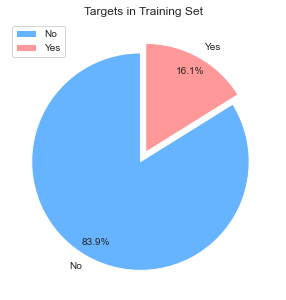

(3087, 11)


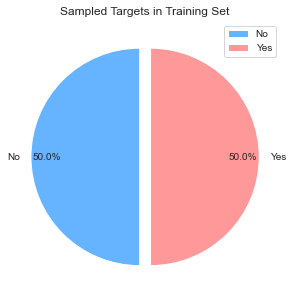

(5178, 11)


In [142]:
# Oversample the minority class and undersample the majority class

sampled_X_train, sampled_y_train = sampling(X_train, y_train, False)

In [143]:
# Run Naive Bayes (Gaussian) modeling

gnb_s_wt_cv = GaussianNB()
gnb_s_wt_cv.fit(sampled_X_train, sampled_y_train)

GaussianNB()

In [144]:
# Display classification summary and accuracy

summary('gnb_s_wt_cv', gnb_s_wt_cv, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 0.6871)

       Prediction
Actual    0    1
     0 1820  769
     1  851 1738
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.6871)

       Prediction
Actual   0   1
     0 778 332
     1  82 131

Precision Score:  0.28293737
Recall Score:  0.61502347
F1 Score:  0.38757396


In [145]:
# Calculate probability for Attrition

pred_prob_test = pd.DataFrame(gnb_s_wt_cv.predict_proba(X_test))
pred_prob_test.rename(columns={0:'Prob_No',1:'Prob_Yes'}, inplace=True)

y_test_pred = pd.DataFrame(gnb_s_wt_cv.predict(X_test))
y_test_pred.rename(columns={0:'Predict'}, inplace=True)

In [146]:
# Concatenate the original data with the probability for Attrition

index = X_test.index
indices = index.to_list()

attr_prob_test = pd.concat([emp_attr.iloc[indices].reset_index(), pred_prob_test, y_test_pred], axis=1)
attr_prob_test.head()

,index,AvgHrs,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,...,WkDays,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,MonthlyIncomeCAD,Prob_No,Prob_Yes,Predict
0,1114,6.986116,39,0,3,2,1,3,5,0,...,230,1,1,3,3,3,1681,0.835249,0.164751,0
1,3239,7.127433,35,0,1,2,5,1,4,1,...,231,4,1,4,3,3,826,0.473110,0.526890,1
2,3026,7.913147,35,0,3,3,16,2,6,1,...,231,3,2,3,4,3,407,0.779274,0.220726,0
3,1704,7.006801,48,0,3,2,8,1,4,1,...,234,4,1,1,4,3,860,0.676867,0.323133,0
4,2905,6.934340,38,0,3,2,1,2,4,1,...,232,1,3,2,3,3,1035,0.944020,0.055980,0


In [147]:
# Shift Attrition to the last column

attr = attr_prob_test.pop('Attrition')
attr_prob_test.insert(len(attr_prob_test.columns),'Attrition', attr)
attr_prob_test.head()

,index,AvgHrs,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,...,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,MonthlyIncomeCAD,Prob_No,Prob_Yes,Predict,Attrition
0,1114,6.986116,39,3,2,1,3,5,0,1,...,1,1,3,3,3,1681,0.835249,0.164751,0,0
1,3239,7.127433,35,1,2,5,1,4,1,1,...,4,1,4,3,3,826,0.473110,0.526890,1,0
2,3026,7.913147,35,3,3,16,2,6,1,3,...,3,2,3,4,3,407,0.779274,0.220726,0,0
3,1704,7.006801,48,3,2,8,1,4,1,2,...,4,1,1,4,3,860,0.676867,0.323133,0,0
4,2905,6.934340,38,3,2,1,2,4,1,4,...,1,3,2,3,3,1035,0.944020,0.055980,0,0


##### 3.3.2.1 RandomizedSearchCV

In [148]:
# Set hyperparameters

param_grid_nb = {'var_smoothing':np.logspace(0, -9, num=100)}

In [149]:
# Use RandomizedSearchCV to select the best hyperparameters
# Run Naive Bayes (Gaussian) modeling

nbModel_grid = RandomizedSearchCV(GaussianNB(), param_distributions=param_grid_nb, 
                                  n_iter=100, scoring="accuracy", random_state=1,
                                  n_jobs=-1, cv=10, return_train_score=True)
nbModel_grid.fit(sampled_X_train, sampled_y_train)

RandomizedSearchCV(cv=10, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-...
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=1, return_train_score=True, scoring='accuracy')

In [150]:
# Display the optimal parameters

gnb_s_w_rs = nbModel_grid.best_estimator_
gnb_s_w_rs

GaussianNB(var_smoothing=1.873817422860383e-05)

In [151]:
# Display classification summary and accuracy

summary('gnb_s_w_rs', gnb_s_w_rs, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 0.6871)

       Prediction
Actual    0    1
     0 1819  770
     1  850 1739
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.6871)

       Prediction
Actual   0   1
     0 778 332
     1  82 131

Precision Score:  0.28293737
Recall Score:  0.61502347
F1 Score:  0.38757396


### 3.4 Logistic Regression

In [152]:
# Encode categorical features

emp_attr_lr_encode = getDummies(emp_attr_lr, True)

In [153]:
# Drop the encoded categorical features and target variable

encode_list = emp_attr_lr_encode.loc[:,emp_attr_lr_encode.dtypes==np.uint8].columns
X_num = emp_attr_lr_encode.drop(columns=['Attrition']).drop(columns=encode_list)

In [154]:
# Standardize features by using MinMaxScaler
# MinMaxScaler: values are scaled in the range between 0 and 1

X_num = scaling(X_num)

In [155]:
# Concatenate scaled numerical features with categorical features

emp_attr_lr_encode_scaled = pd.concat([X_num, emp_attr_lr_encode.drop(columns=X_num.columns)], axis=1)
emp_attr_lr_encode_scaled.head()

,Age,WkDays,YearsSinceLastPromotion_Trans,MonthlyIncomeCAD_Trans,DistanceFromHome_Trans,YearsAtCompany_Trans,TotalWorkingYears_Trans,NumCompaniesWorked_Trans,AvgHrs_Trans,PercentSalaryHike_Trans,...,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,PerformanceRating_4
0,0.785714,0.304348,0.000000,0.892796,0.455371,0.158369,0.114002,0.318568,0.481584,0.000000,...,0,0,1,1,0,0,0,1,0,0
1,0.309524,0.478261,0.407877,0.552095,0.622701,0.434173,0.389589,0.000000,0.562175,0.939124,...,1,0,0,0,0,1,1,0,0,1
2,0.333333,0.739130,0.000000,0.991692,0.806883,0.434173,0.349938,0.318568,0.385182,0.500904,...,1,0,0,0,0,0,0,1,0,0
3,0.476190,0.434783,0.872522,0.766355,0.146043,0.544257,0.591937,0.621701,0.435157,0.000000,...,0,0,1,0,1,0,1,0,0,0
4,0.333333,0.869565,0.000000,0.345220,0.622701,0.475475,0.488546,0.716128,0.621762,0.160094,...,0,0,0,0,1,0,0,1,0,0


In [156]:
# Split the data into Train (70%) and Test (30%)

X = emp_attr_lr_encode_scaled.drop(columns=['Attrition'])
y = emp_attr_lr_encode_scaled['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

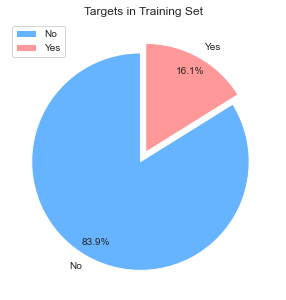

(3087, 55)


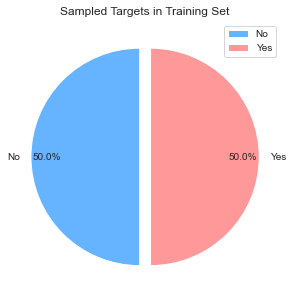

(5178, 55)


In [157]:
# Oversample the minority class and undersample the majority class

sampled_X_train, sampled_y_train = sampling(X_train, y_train, False)

In [158]:
# Run Logistic Regression modeling

lr_s_wt_cv = LogisticRegression(solver='liblinear', random_state=1, C=1e42)
lr_s_wt_cv.fit(sampled_X_train, sampled_y_train)

LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [159]:
# Display the intercept

lr_s_wt_cv.intercept_

array([10.09865818])

In [160]:
# Display the coefficients and odds ratio

coeffdf = pd.DataFrame({'coef': lr_s_wt_cv.coef_[0]}, index=X.columns)
coeffdf['odds'] = np.e**coeffdf['coef']
coeffdf.sort_values('odds', ascending=False)

,coef,odds
AvgHrs_Trans,2.022120,7.554323
YearsSinceLastPromotion_Trans,1.157993,3.183539
NumCompaniesWorked_Trans,1.004108,2.729472
BusinessTravel_2,0.845741,2.329703
MaritalStatus_3,0.658652,1.932186
PercentSalaryHike_Trans,0.284377,1.328934
BusinessTravel_3,0.211003,1.234917
JobLevel_4,0.065940,1.068162
WkDays,0.028174,1.028575
Gender_1,-0.054471,0.946986


***
Findings:

The above analysis on correlation coefficient and odds ratio shows that every unit change in AvgHrs, the employee is 8 times more likely to leave the company. And, every unit change in YearsSinceLastPromotion, the employee is 3 times more likely to leave the company. Whereas every unit change in EducatoinField_5 (Other) and TotalWorkingYears, the employee is 89% and 98% less likely to leave the company, respectively. 
***

In [161]:
# Display classification summary and accuracy

summary('lr_s_wt_cv', lr_s_wt_cv, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 0.8241)

       Prediction
Actual    0    1
     0 2184  405
     1  506 2083
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.8088)

       Prediction
Actual   0   1
     0 942 168
     1  85 128

Precision Score:  0.43243243
Recall Score:  0.60093897
F1 Score:  0.50294695


In [162]:
# Predict the probability of Attrition for each record

logit_reg_prob = lr_s_wt_cv.predict_proba(X_test)
logit_reg_pred = lr_s_wt_cv.predict(X_test)
logit_result = pd.DataFrame({'actual':y_test,
                             'p_0':[p[0] for p in logit_reg_prob],
                             'p_1':[p[1] for p in logit_reg_prob],
                             'predicted':logit_reg_pred}).sort_values(by='p_1', ascending=False)
logit_result

,actual,p_0,p_1,predicted
2577,1,0.006854,0.993146,1
913,1,0.010231,0.989769,1
2383,1,0.010247,0.989753,1
1312,1,0.013169,0.986831,1
2782,1,0.014223,0.985777,1
...,...,...,...,...
4342,0,0.996143,0.003857,0
3644,0,0.996562,0.003438,0
853,1,0.997970,0.002030,0
3793,1,0.998011,0.001989,0


<AxesSubplot:title={'center':'Decile Lift Chart'}, xlabel='Percentile', ylabel='Lift'>

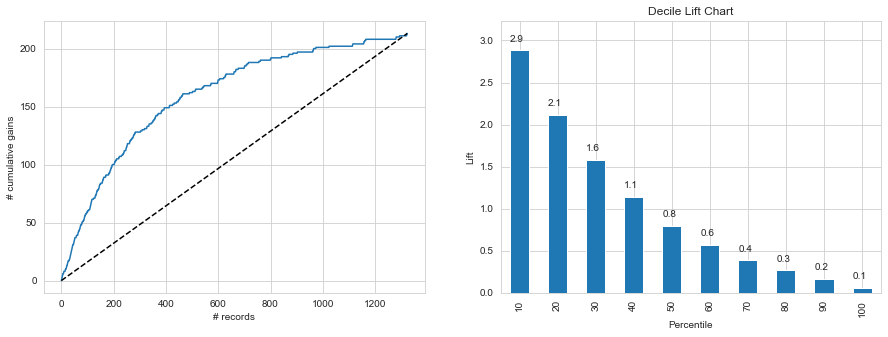

In [163]:
# Visualize Cumulative Gains and Lift

fig, axes = plt.subplots(1, 2, figsize=[15,5])
gainsChart(logit_result['actual'], ax=axes[0])
liftChart(logit_result['p_1'], ax=axes[1])

***
Findings:

From the above Cumulative Gain and Lift Charts, the top 10% of employee records give the highest predicted attrition. For example, we would gain 2.9 times the number of attrition, compared to choosing 10% of the employee records at random. This lift number is computed from the cumulative gains chart by comparing the number of attrition for 132 random employees (the value of the baseline curve at x = 132), which is around 20 with the actual attrition of the 132 employees that have the highest predicted attrition (the value of the cumulative gains curve at x = 132), which is around 60. The ratio between these numbers is about 3.
***

#### 3.4.1 RandomizedSearchCV

In [164]:
# Set hyperparameters

params_lr = {'C':np.logspace(-3,5), 'penalty':['l1','l2'], 'solver':['liblinear','saga']}

In [165]:
# Use RandomizedSearchCV to select the best hyperparameters
# Run Logistic Regression modeling

rs_lr = RandomizedSearchCV(LogisticRegression(random_state=1),
                           param_distributions=params_lr,
                           n_iter=50, scoring="accuracy", random_state=1,
                           n_jobs=-1, cv=10, return_train_score=True)
rs_lr.fit(sampled_X_train, sampled_y_train)

RandomizedSearchCV(cv=10, estimator=LogisticRegression(random_state=1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 1.45634848e-03, 2.12095089e-03, 3.08884360e-03,
       4.49843267e-03, 6.55128557e-03, 9.54095476e-03, 1.38949549e-02,
       2.02358965e-02, 2.94705170e-02, 4.29193426e-02, 6.25055193e-02,
       9.10298178e-02, 1.32571137e-01, 1.93069773e-01, 2.8...
       1.67683294e+02, 2.44205309e+02, 3.55648031e+02, 5.17947468e+02,
       7.54312006e+02, 1.09854114e+03, 1.59985872e+03, 2.32995181e+03,
       3.39322177e+03, 4.94171336e+03, 7.19685673e+03, 1.04811313e+04,
       1.52641797e+04, 2.22299648e+04, 3.23745754e+04, 4.71486636e+04,
       6.86648845e+04, 1.00000000e+05]),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=1, return_train_score=True, scoring='accuracy')

In [166]:
# Display the optimal parameters

lr_s_w_rs = rs_lr.best_estimator_
lr_s_w_rs

LogisticRegression(C=0.19306977288832497, random_state=1, solver='liblinear')

In [167]:
# Display the intercept

lr_s_w_rs.intercept_

array([4.87848082])

In [168]:
# Display the coefficients and odds ratio

coeffdf = pd.DataFrame({'coef': lr_s_w_rs.coef_[0]}, index=X.columns)
coeffdf['odds'] = np.e**coeffdf['coef']
coeffdf.sort_values('odds', ascending=False)

,coef,odds
AvgHrs_Trans,1.862989,6.442966
BusinessTravel_2,0.912677,2.490982
NumCompaniesWorked_Trans,0.892794,2.441943
YearsSinceLastPromotion_Trans,0.794004,2.212238
MaritalStatus_3,0.738478,2.092748
PercentSalaryHike_Trans,0.570529,1.769203
BusinessTravel_3,0.387676,1.473553
WkDays,0.302552,1.353308
MaritalStatus_2,0.076583,1.079591
Gender_1,0.053406,1.054858


***
Findings:

The above analysis on correlation coefficient and odds ratio shows that every unit change in AvgHrs, the employee is 6 times more likely to leave the company. And, every unit change in BusinessTravel_2 (Travel Frequently), the employee is 2 times more likely to leave the company. Whereas every unit change in JobRole_5 (Manufacturing Director) and TotalWorkingYears, the employee is 77% and 88% less likely to leave the company, respectively. 
***

In [169]:
# Display classification summary and accuracy

summary('lr_s_w_rs', lr_s_w_rs, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 0.8239)

       Prediction
Actual    0    1
     0 2202  387
     1  525 2064
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.8209)

       Prediction
Actual   0   1
     0 957 153
     1  84 129

Precision Score:  0.45744681
Recall Score:  0.6056338
F1 Score:  0.52121212


In [170]:
# Predict the probability of Attrition for each record

logit_reg_prob = lr_s_w_rs.predict_proba(X_test)
logit_reg_pred = lr_s_w_rs.predict(X_test)
logit_result = pd.DataFrame({'actual':y_test,
                             'p_0':[p[0] for p in logit_reg_prob],
                             'p_1':[p[1] for p in logit_reg_prob],
                             'predicted':logit_reg_pred}).sort_values(by='p_1', ascending=False)
logit_result

,actual,p_0,p_1,predicted
2383,1,0.028702,0.971298,1
913,1,0.028998,0.971002,1
1312,1,0.049481,0.950519,1
2577,1,0.052788,0.947212,1
2782,1,0.054070,0.945930,1
...,...,...,...,...
951,0,0.983684,0.016316,0
4342,0,0.989730,0.010270,0
853,1,0.990075,0.009925,0
3793,1,0.990600,0.009400,0


<AxesSubplot:title={'center':'Decile Lift Chart'}, xlabel='Percentile', ylabel='Lift'>

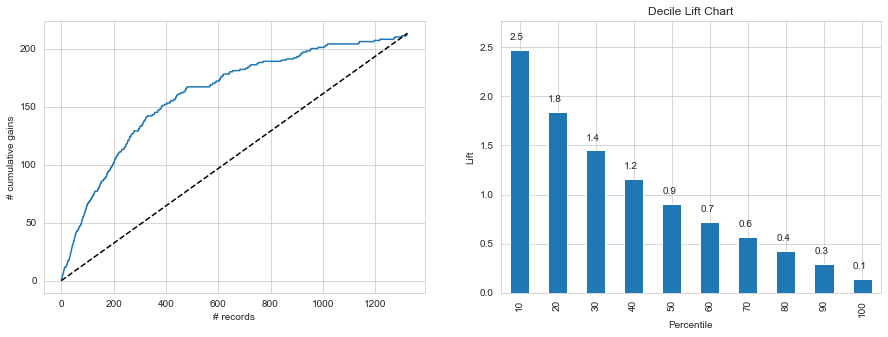

In [171]:
# Visualize Cumulative Gains and Lift

fig, axes = plt.subplots(1, 2, figsize=[15,5])
gainsChart(logit_result['actual'], ax=axes[0])
liftChart(logit_result['p_1'], ax=axes[1])

***
Findings:

From the above Cumulative Gain and Lift Charts, the top 10% of employee records give the highest predicted attrition. For example, we would gain 2.5 times the number of attrition, compared to choosing 10% of the employee records at random. This lift number is computed from the cumulative gains chart by comparing the number of attrition for 132 random employees (the value of the baseline curve at x = 132), which is around 25 with the actual attrition of the 132 employees that have the highest predicted attrition (the value of the cumulative gains curve at x = 132), which is around 60. The ratio between these numbers is about 2.5.
***

#### 3.4.2 AdaBoostClassifier

In [172]:
# Use AdaBoostClassifier to boost the performance of Logistic Regression modeling
# Run AdaBoostClassifier 

lr_s_boost = AdaBoostClassifier(LogisticRegression(solver='liblinear', random_state=1, C=1e42),
                                n_estimators=100, random_state=1)
lr_s_boost.fit(sampled_X_train, sampled_y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(C=1e+42, random_state=1,
                                                     solver='liblinear'),
                   n_estimators=100, random_state=1)

In [173]:
# Display classification summary and accuracy

summary('lr_s_boost', lr_s_boost, sampled_y_train, sampled_X_train, y_test, X_test)  

Train classification summary:
Confusion Matrix (Accuracy 0.8190)

       Prediction
Actual    0    1
     0 2160  429
     1  508 2081
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.7906)

       Prediction
Actual   0   1
     0 924 186
     1  91 122

Precision Score:  0.3961039
Recall Score:  0.57276995
F1 Score:  0.46833013


#### 3.4.3 BaggingClassifier

In [174]:
# Use BaggingClassifier to boost the performance of Logistic Regression modeling
# Run BaggingClassifier 

lr_s_bag = BaggingClassifier(LogisticRegression(solver='liblinear', random_state=1, C=1e42), 
                             n_estimators=100, random_state=1)
lr_s_bag.fit(sampled_X_train, sampled_y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1e+42, random_state=1,
                                                    solver='liblinear'),
                  n_estimators=100, random_state=1)

In [175]:
# Display classification summary and accuracy

summary('lr_s_bag', lr_s_bag, sampled_y_train, sampled_X_train, y_test, X_test)  

Train classification summary:
Confusion Matrix (Accuracy 0.8237)

       Prediction
Actual    0    1
     0 2183  406
     1  507 2082
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.8103)

       Prediction
Actual   0   1
     0 944 166
     1  85 128

Precision Score:  0.43537415
Recall Score:  0.60093897
F1 Score:  0.50493097


#### 3.4.4 Additional Work

##### 3.4.4.1 Logistic Regression without scaling

In [176]:
# Encode categorical features

emp_attr_lr_encode = getDummies(emp_attr_lr, True)

In [177]:
# Split the data into Train (70%) and Test (30%)

X = emp_attr_lr_encode.drop(columns=['Attrition'])
y = emp_attr_lr_encode['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

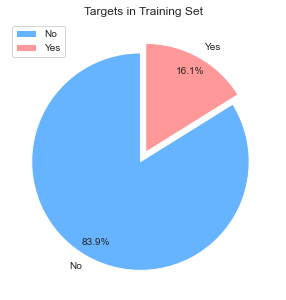

(3087, 55)


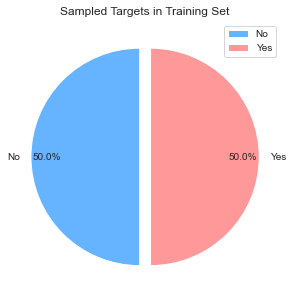

(5178, 55)


In [178]:
# Oversample the minority class and undersample the majority class

sampled_X_train, sampled_y_train = sampling(X_train, y_train, False)

In [179]:
# Run Logistic Regression modeling

lr_s_wt_scale = LogisticRegression(solver='liblinear', random_state=1, C=1e42)
lr_s_wt_scale.fit(sampled_X_train, sampled_y_train)

LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [180]:
# Display the intercept

lr_s_wt_scale.intercept_

array([8.52722824])

In [181]:
# Display the coefficients and odds ratio

coeffdf = pd.DataFrame({'coef': lr_s_wt_scale.coef_[0]}, index=X.columns)
coeffdf['odds'] = np.e**coeffdf['coef']
coeffdf.sort_values('odds',ascending=False)

,coef,odds
BusinessTravel_2,0.628362,1.874538
MaritalStatus_3,0.625711,1.869575
AvgHrs_Trans,0.561128,1.752648
YearsSinceLastPromotion_Trans,0.363782,1.438760
JobLevel_4,0.327001,1.386802
NumCompaniesWorked_Trans,0.293136,1.340625
PercentSalaryHike_Trans,0.081915,1.085363
JobRole_6,0.001191,1.001192
WkDays,-0.003110,0.996894
Age,-0.013107,0.986979


***
Findings:

The above analysis on correlation coefficient and odds ratio shows that every unit change in both BusinessTravel_2 (Travel Frequently) and MaritalStatus_3 (Single), the employee is 87% more likely to leave the company. Whereas every unit change in Education_3 (Bachelor) and Education_5 (Doctor), the employee is 90% and 94% less likely to leave the company, respectively. 
***

In [182]:
# Display classification summary and accuracy

summary('lr_s_wt_scale', lr_s_wt_scale, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 0.8681)

       Prediction
Actual    0    1
     0 2352  237
     1  446 2143
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.8413)

       Prediction
Actual    0    1
     0 1018   92
     1  118   95

Precision Score:  0.50802139
Recall Score:  0.44600939
F1 Score:  0.475


In [183]:
# Predict the probability of Attrition for each record

logit_reg_prob = lr_s_wt_scale.predict_proba(X_test)
logit_reg_pred = lr_s_wt_scale.predict(X_test)
logit_result = pd.DataFrame({'actual':y_test,
                             'p_0':[p[0] for p in logit_reg_prob],
                             'p_1':[p[1] for p in logit_reg_prob],
                             'predicted':logit_reg_pred}).sort_values(by='p_1', ascending=False)
logit_result

,actual,p_0,p_1,predicted
2577,1,0.013400,0.986600,1
913,1,0.013779,0.986221,1
2383,1,0.013860,0.986140,1
3475,0,0.029932,0.970068,1
1868,1,0.030354,0.969646,1
...,...,...,...,...
4342,0,0.996806,0.003194,0
4239,0,0.996809,0.003191,0
853,1,0.998137,0.001863,0
3793,1,0.998151,0.001849,0


<AxesSubplot:title={'center':'Decile Lift Chart'}, xlabel='Percentile', ylabel='Lift'>

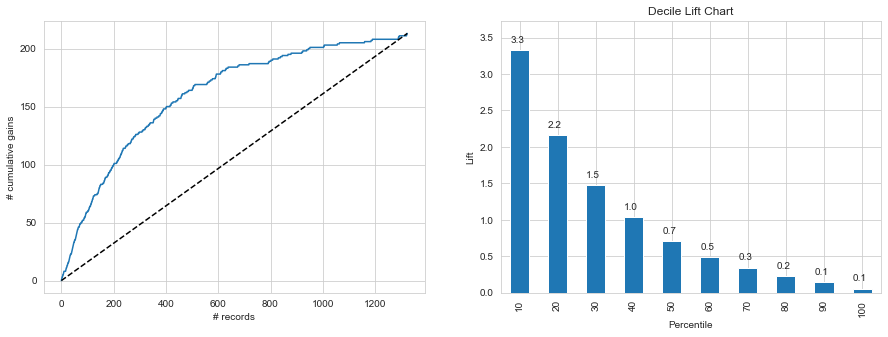

In [184]:
# Visualize Cumulative Gains and Lift

fig, axes = plt.subplots(1, 2, figsize=[15,5])
gainsChart(logit_result['actual'], ax=axes[0])
liftChart(logit_result['p_1'], ax=axes[1])

***
Findings:

From the above Cumulative Gain and Lift Charts, the top 10% of employee records give the highest predicted attrition. For example, we would gain 3.3 times the number of attrition, compared to choosing 10% of the employee records at random. This lift number is computed from the cumulative gains chart by comparing the number of attrition for 132 random employees (the value of the baseline curve at x = 132), which is around 23 with the actual attrition of the 132 employees that have the highest predicted attrition (the value of the cumulative gains curve at x = 132), which is around 75. The ratio between these numbers is about 3.3.
***

### 3.5 K-Nearest Neighbors

In [185]:
# Encode categorical features

emp_attr_knn_encode = getDummies(emp_attr_knn, True)

In [186]:
# Drop the encoded categorical features and target variable

encode_list = emp_attr_knn_encode.loc[:,emp_attr_knn_encode.dtypes==np.uint8].columns
X_num = emp_attr_knn_encode.drop(columns=['Attrition']).drop(columns=encode_list)

In [187]:
# Standardize features by using MinMaxScaler
# MinMaxScaler: values are scaled in the range between 0 and 1

X_num = scaling(X_num)

In [188]:
# Concatenate scaled numerical features with categorical features

emp_attr_knn_encode_scaled = pd.concat([X_num, emp_attr_knn_encode.drop(columns = X_num.columns)], axis=1)
emp_attr_knn_encode_scaled.head()

,Age,WkDays,YearsSinceLastPromotion_Trans,MonthlyIncomeCAD_Trans,DistanceFromHome_Trans,YearsAtCompany_Trans,TotalWorkingYears_Trans,NumCompaniesWorked_Trans,AvgHrs_Trans,PercentSalaryHike_Trans,...,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,PerformanceRating_4
0,0.785714,0.304348,0.000000,0.892796,0.455371,0.158369,0.114002,0.318568,0.481584,0.000000,...,0,0,1,1,0,0,0,1,0,0
1,0.309524,0.478261,0.407877,0.552095,0.622701,0.434173,0.389589,0.000000,0.562175,0.939124,...,1,0,0,0,0,1,1,0,0,1
2,0.333333,0.739130,0.000000,0.991692,0.806883,0.434173,0.349938,0.318568,0.385182,0.500904,...,1,0,0,0,0,0,0,1,0,0
3,0.476190,0.434783,0.872522,0.766355,0.146043,0.544257,0.591937,0.621701,0.435157,0.000000,...,0,0,1,0,1,0,1,0,0,0
4,0.333333,0.869565,0.000000,0.345220,0.622701,0.475475,0.488546,0.716128,0.621762,0.160094,...,0,0,0,0,1,0,0,1,0,0


In [189]:
# Split the data into Train (70%) and Test (30%)

X = emp_attr_knn_encode_scaled.drop(columns=['Attrition'])
y = emp_attr_knn_encode_scaled['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

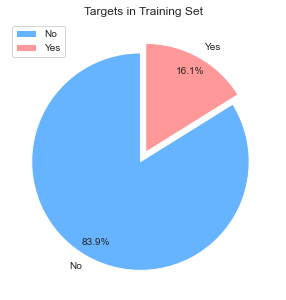

(3087, 55)


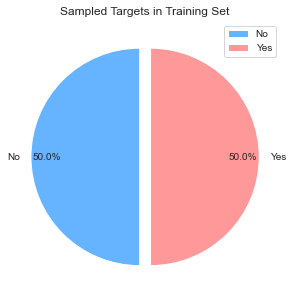

(5178, 55)


In [190]:
# Oversample the minority class and undersample the majority class

sampled_X_train, sampled_y_train = sampling(X_train, y_train, False)

In [191]:
# Run K-Nearest Neighbors modeling

knn_s_wt_cv = KNeighborsClassifier()
knn_s_wt_cv.fit(sampled_X_train, sampled_y_train)

KNeighborsClassifier()

In [192]:
# Display classification summary and accuracy

summary('knn_s_wt_cv', knn_s_wt_cv, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 0.9424)

       Prediction
Actual    0    1
     0 2293  296
     1    2 2587
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.7748)

       Prediction
Actual   0   1
     0 822 288
     1  10 203

Precision Score:  0.41344196
Recall Score:  0.95305164
F1 Score:  0.57670455


##### 3.5.1 GridSearchCV

In [193]:
# Use GridSearchCV to select the best hyperparameters
# Run K-Nearest Neighbors modeling

knn = KNeighborsClassifier()
param_knn = {'n_neighbors':np.arange(1, 20)}
gs_knn = GridSearchCV(knn, param_knn, cv=10, scoring='accuracy', 
                      return_train_score=False, verbose=1)
gs_knn.fit(sampled_X_train, sampled_y_train)

Fitting 10 folds for each of 19 candidates, totalling 190 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='accuracy', verbose=1)

In [194]:
# Display the optimal parameters

knn_s_w_cv = gs_knn.best_estimator_
knn_s_w_cv

KNeighborsClassifier(n_neighbors=2)

In [195]:
# Display classification summary and accuracy

summary('knn_s_w_cv', knn_s_w_cv, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2589    0
     1    0 2589
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.9690)

       Prediction
Actual    0    1
     0 1078   32
     1    9  204

Precision Score:  0.86440678
Recall Score:  0.95774648
F1 Score:  0.90868597


### 3.6 Voting Classifier

VotingClassifier is useful to balance out the weaknesses of individual model. It combines different models and uses the average predicted probabilities (soft vote) to predict Attrition.

In [196]:
# Run VotingClassifier on 3 sub-models from Logistic Regression and K-Nearest Neighbors

vc3 = VotingClassifier(estimators=[('lr_s_wt_cv', lr_s_wt_cv), ('lr_s_w_rs', rs_lr), 
                                   ('knn_s_wt_cv', knn_s_wt_cv)],
                                  voting='soft', weights=[2,2,1])
vc3.fit(sampled_X_train, sampled_y_train)

VotingClassifier(estimators=[('lr_s_wt_cv',
                              LogisticRegression(C=1e+42, random_state=1,
                                                 solver='liblinear')),
                             ('lr_s_w_rs',
                              RandomizedSearchCV(cv=10,
                                                 estimator=LogisticRegression(random_state=1),
                                                 n_iter=50, n_jobs=-1,
                                                 param_distributions={'C': array([1.00000000e-03, 1.45634848e-03, 2.12095089e-03, 3.08884360e-03,
       4.49843267e-03, 6.55128557e-03, 9.54095476e-03, 1.38...
       7.54312006e+02, 1.09854114e+03, 1.59985872e+03, 2.32995181e+03,
       3.39322177e+03, 4.94171336e+03, 7.19685673e+03, 1.04811313e+04,
       1.52641797e+04, 2.22299648e+04, 3.23745754e+04, 4.71486636e+04,
       6.86648845e+04, 1.00000000e+05]),
                                                                      'penalty': ['l1',
                                                                                  'l2'],
                                                                      'solver': ['liblinear',
                                                                                 'saga']},
                                                 random_state=1,
                                                 return_train_score=True,
                                                 scoring='accuracy')),
                             ('knn_s_wt_cv', KNeighborsClassifier())],
                 voting='soft', weights=[2, 2, 1])

In [197]:
# Display classification summary and accuracy

summary('vc3', vc3, sampled_y_train, sampled_X_train, y_test, X_test)

Train classification summary:
Confusion Matrix (Accuracy 0.8874)

       Prediction
Actual    0    1
     0 2319  270
     1  313 2276
--------------------------------------------------------------------------

Test classification summary:
Confusion Matrix (Accuracy 0.8541)

       Prediction
Actual   0   1
     0 978 132
     1  61 152

Precision Score:  0.53521127
Recall Score:  0.71361502
F1 Score:  0.61167002


### 3.7 ROC Curve and AUC

Decision Tree model with the best AUC is: dt_s_w_rs_boost[0.99534323]



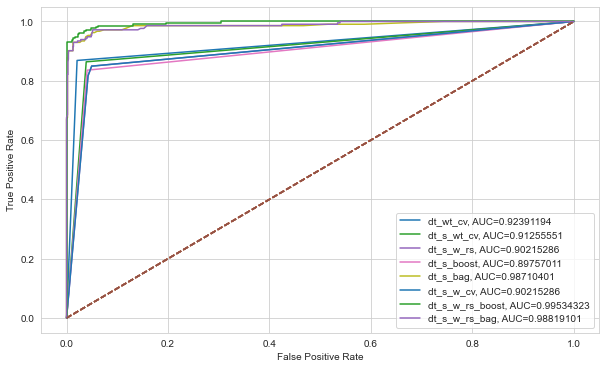

In [198]:
# Visualize ROC Curve and AUC of all sub-models in Decision Tree

dt_list_fpr = [fpr_dt_wt_cv,fpr_dt_s_wt_cv,fpr_dt_s_w_rs,fpr_dt_s_boost,fpr_dt_s_bag,
               fpr_dt_s_w_cv,fpr_dt_s_w_rs_boost,fpr_dt_s_w_rs_bag]
dt_list_tpr = [tpr_dt_wt_cv,tpr_dt_s_wt_cv,tpr_dt_s_w_rs,tpr_dt_s_boost,tpr_dt_s_bag,
               tpr_dt_s_w_cv,tpr_dt_s_w_rs_boost,tpr_dt_s_w_rs_bag]
dt_list_auc = [auc_dt_wt_cv,auc_dt_s_wt_cv,auc_dt_s_w_rs, auc_dt_s_boost, auc_dt_s_bag,
               auc_dt_s_w_cv,auc_dt_s_w_rs_boost,auc_dt_s_w_rs_bag]
dt_list = ['dt_wt_cv','dt_s_wt_cv','dt_s_w_rs','dt_s_boost','dt_s_bag',
           'dt_s_w_cv','dt_s_w_rs_boost','dt_s_w_rs_bag']

highestAUC_score = 0
plt.subplots(1, figsize=(10,6))

for i, j, k, l in zip(dt_list_fpr, dt_list_tpr, dt_list_auc, dt_list):
  if k > highestAUC_score:
    highestAUC_score = k
    highestAUC_model = l
  plt.plot(i, j, label=str(l)+', AUC='+str(k))
  plt.plot([0,1], ls='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc='lower right')

print('Decision Tree model with the best AUC is: '+str(highestAUC_model)+'['+str(highestAUC_score)+']\n')

Random Forest model with the best AUC is: rf_wt_cv[0.99559278]



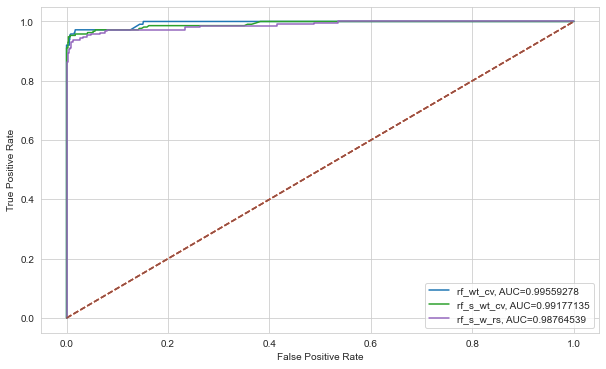

In [199]:
# Visualize the ROC Curve and AUC of all sub-models in Random Forest

rf_list_fpr = [fpr_rf_wt_cv,fpr_rf_s_wt_cv,fpr_rf_s_w_rs]
rf_list_tpr = [tpr_rf_wt_cv,tpr_rf_s_wt_cv,tpr_rf_s_w_rs]
rf_list_auc = [auc_rf_wt_cv,auc_rf_s_wt_cv,auc_rf_s_w_rs]
rf_list = ['rf_wt_cv','rf_s_wt_cv','rf_s_w_rs']

highestAUC_score = 0
plt.subplots(1, figsize=(10,6))

for i, j, k, l in zip(rf_list_fpr, rf_list_tpr, rf_list_auc, rf_list):
  if k > highestAUC_score:
    highestAUC_score = k
    highestAUC_model = l
  plt.plot(i, j, label=str(l)+', AUC='+str(k))
  plt.plot([0,1], ls='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc='lower right')

print('Random Forest model with the best AUC is: '+str(highestAUC_model)+'['+str(highestAUC_score)+']\n')

Naive Bayes model with the best AUC is: gnb_s_w_rs[0.70203866]



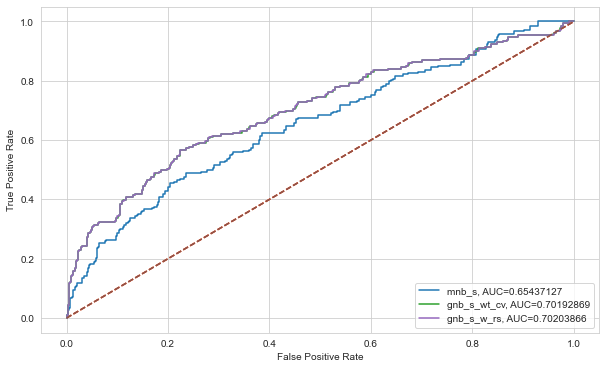

In [200]:
# Visualize the ROC Curve and AUC of all sub-models in Naive Bayes

nb_list_fpr = [fpr_mnb_s,fpr_gnb_s_wt_cv,fpr_gnb_s_w_rs]
nb_list_tpr = [tpr_mnb_s,tpr_gnb_s_wt_cv,tpr_gnb_s_w_rs]
nb_list_auc = [auc_mnb_s,auc_gnb_s_wt_cv,auc_gnb_s_w_rs]
nb_list = ['mnb_s','gnb_s_wt_cv','gnb_s_w_rs']

highestAUC_score = 0
plt.subplots(1, figsize=(10,6))

for i, j, k, l in zip(nb_list_fpr, nb_list_tpr, nb_list_auc, nb_list):
  if k > highestAUC_score:
    highestAUC_score = k
    highestAUC_model = l
  plt.plot(i, j, label=str(l)+', AUC='+str(k))
  plt.plot([0,1], ls='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc='lower right')

print('Naive Bayes model with the best AUC is: '+str(highestAUC_model)+'['+str(highestAUC_score)+']\n')

Logistic Regression model with the best AUC is: lr_s_w_rs[0.80342596]



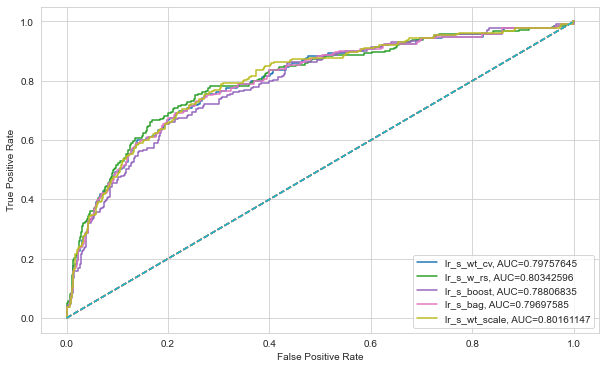

In [201]:
# Visualize the ROC Curve and AUC of all sub-models in Logistic Regression

lr_list_fpr = [fpr_lr_s_wt_cv,fpr_lr_s_w_rs,fpr_lr_s_boost,fpr_lr_s_bag,
               fpr_lr_s_wt_scale]
lr_list_tpr = [tpr_lr_s_wt_cv,tpr_lr_s_w_rs,tpr_lr_s_boost,tpr_lr_s_bag,
               tpr_lr_s_wt_scale]
lr_list_auc = [auc_lr_s_wt_cv,auc_lr_s_w_rs,auc_lr_s_boost,auc_lr_s_bag,
               auc_lr_s_wt_scale]
lr_list = ['lr_s_wt_cv','lr_s_w_rs','lr_s_boost','lr_s_bag','lr_s_wt_scale']

highestAUC_score = 0
plt.subplots(1, figsize=(10,6))

for i, j, k, l in zip(lr_list_fpr, lr_list_tpr, lr_list_auc, lr_list):
  if k > highestAUC_score:
    highestAUC_score = k
    highestAUC_model = l
  plt.plot(i, j, label=str(l)+', AUC='+str(k))
  plt.plot([0,1], ls='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc='lower right')

print('Logistic Regression model with the best AUC is: '+str(highestAUC_model)+'['+str(highestAUC_score)+']\n')

K-Nearest Neighbors model with the best AUC is: knn_s_w_cv[0.96137546]



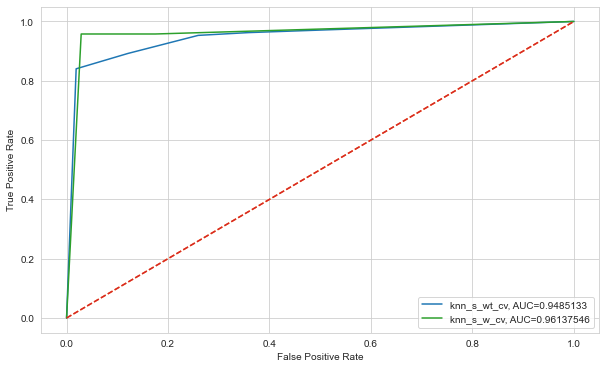

In [202]:
# Visualize the ROC Curve and AUC of all sub-models in K-Nearest Neighbors

knn_list_fpr = [fpr_knn_s_wt_cv,fpr_knn_s_w_cv]
knn_list_tpr = [tpr_knn_s_wt_cv,tpr_knn_s_w_cv]
knn_list_auc = [auc_knn_s_wt_cv,auc_knn_s_w_cv]
knn_list = ['knn_s_wt_cv','knn_s_w_cv']

highestAUC_score = 0
plt.subplots(1, figsize=(10,6))

for i, j, k, l in zip(knn_list_fpr, knn_list_tpr, knn_list_auc, knn_list):
  if k > highestAUC_score:
    highestAUC_score = k
    highestAUC_model = l
  plt.plot(i, j, label=str(l)+', AUC='+str(k))
  plt.plot([0,1], ls='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc='lower right')

print('K-Nearest Neighbors model with the best AUC is: '+str(highestAUC_model)+'['+str(highestAUC_score)+']\n')

# 4.0 Model Performance

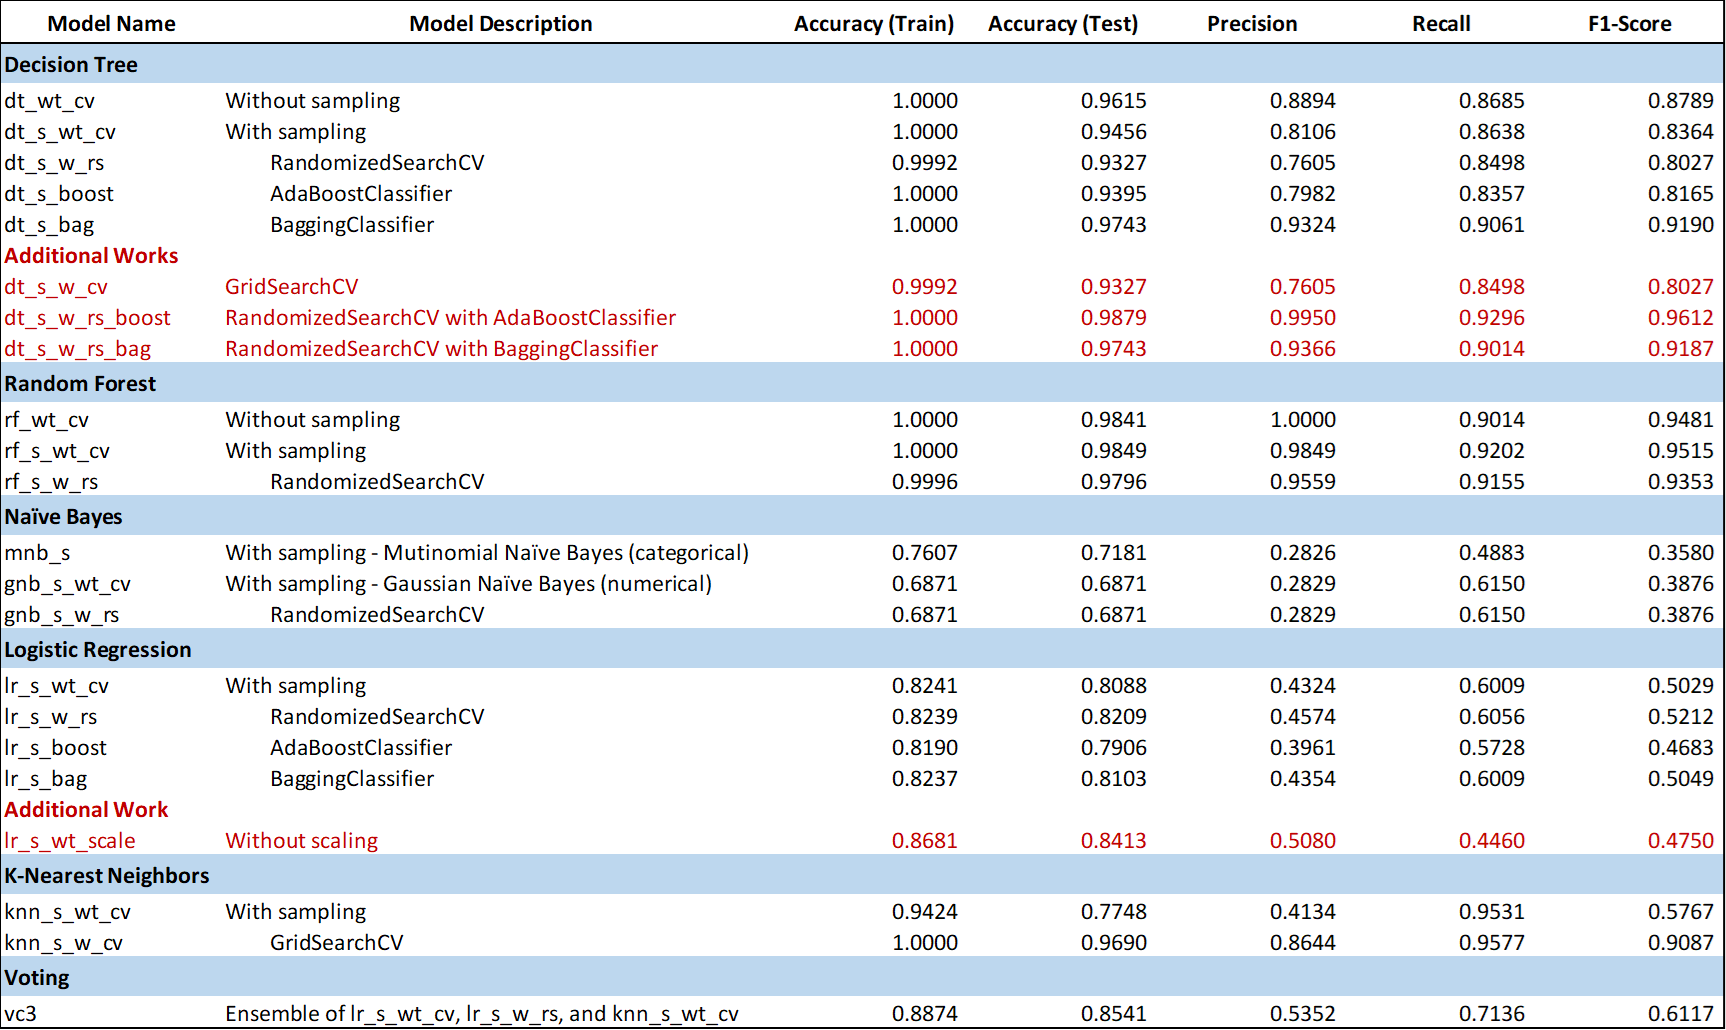